# Followers Graphs

The goal here is to construct a follower graph on Mastodon using the `GET /api/v1/directory HTTP/1.1` endpoint

## Setup

In [4]:
import pandas as pd
import numpy as np
import requests as re
import time
import os
import sqlite3
import json
import random
# from mastodon import Mastodon
import networkx as nx

import matplotlib.pyplot as plt

### Pandas Set up

In [5]:
# pandas options
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Check how the followers thing is working

According to https://docs.joinmastodon.org/methods/directory/

The `GET /api/v1/directory HTTP/1.1` endpoint returns "A directory of profiles that your website is aware of."

I think this is exactly what we would want!



In [6]:
offset = 80

In [34]:
req_stem = "https://hci.social/api/v1/directory?limit=80&local=true&order=new&offset={offset}"
req_query = req_stem.format(offset=offset)
r = re.get(req_query)


try:
    profiles = r.json()
except Exception as e:
    print(e, offset)

In [35]:
print(profiles[0])

{'id': '109467428920172086', 'username': 'AKWILL', 'acct': 'AKWILL', 'display_name': 'Alicia', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-06T00:00:00.000Z', 'note': '<p>PhD Candidate at UMSI studying mental health informatics, health equity, and UX practices. RPCV, knitter, lizard/cat mom, she/they. Probably proud of you 🌈💅🥳</p>', 'url': 'https://hci.social/@AKWILL', 'uri': 'https://hci.social/users/AKWILL', 'avatar': 'https://hci.social/avatars/original/missing.png', 'avatar_static': 'https://hci.social/avatars/original/missing.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 2, 'following_count': 5, 'statuses_count': 0, 'last_status_at': None, 'noindex': False, 'emojis': [], 'roles': [], 'fields': []}


In [36]:
len(profiles)

80

### Some helper functions

In [7]:
def select_relevant_fields(iterable): 
    """
    Just a map to pull certain things out of the json
    
    """
    smaller_json = list(map(lambda x: 
                            dict(
                                id=x["id"],
                                acct=x["acct"],
                                url=x["url"], # so we can tell which server!
                                created_at=x["created_at"],
                                followers_count=x["followers_count"],
                                following_count=x["following_count"],
                                statuses_count=x["statuses_count"],
                                last_status_at=x["last_status_at"]
                            ), 
                            iterable
                           )
                       )
    
    # add the server
    new_list = []
    for a_dict in smaller_json:
        # add the server name
        
        # need both because there are different urls for local versus not
        a_dict["instance"] = a_dict["url"].split("@")[0].split("/users/")[0]
        
        new_list.append(a_dict)
   
    return new_list

## Do it again!

In [8]:
def pull_profiles(file_path="data/profiles/", local_only=True, offset=0, stride=80, write=True):
    """
    
    """
    profiles_df = pd.DataFrame()
    chunk_df = pd.DataFrame()

    req_stem = "https://hci.social/api/v1/directory?limit=80&local={local_only}&order=new&offset={offset}"
    req_query = req_stem.format(offset=offset, local_only="true" if local_only else "false")
    r = re.get(req_query)

    try:
        profiles = r.json()
    except Exception as e:
        print(e, offset)

    ii = 0

    while len(profiles) > 0:
        # keep going until you run out!

        this_profiles_chunk = pd.DataFrame(select_relevant_fields(profiles))

        # TODO: Don't concat these because we don't want huge CSVs! 
        # the newest thing is at the top, so concat old to the new
        profiles_df = pd.concat([this_profiles_chunk, profiles_df], axis=0)

        # Dataframe for 10 interations
        chunk_df = pd.concat([this_profiles_chunk, chunk_df], axis=0)

        # find out your new min_id
        most_recent_created_time = this_profiles_chunk["created_at"].max()

        if (ii + 1) % 10 == 0:
            print("caching results") 
            if write:
                chunk_df.to_csv(file_path + "{}_profile_chunk_{}.csv".format("local" if local_only else "global", ii), index=False)
            chunk_df = pd.DataFrame()

        ii += 1
        offset += stride

        print("I am so proud of you, the last profile was created at {}".format(most_recent_created_time))

        # don't get booted off the API
        time.sleep(1)

        # make another call
        req_query = req_stem.format(offset=offset, local_only="true" if local_only else "false")
        r = re.get(req_query)

        try:
            profiles = r.json()
        except Exception as e:
            print(e, offset)


    print("DONE! You did so good!!")
            
    if write:
        profiles_df.to_csv(file_path + "hci_social_profiles_{}.csv".format("local" if local_only else "global"), index=False)
    
    return profiles_df


In [8]:
local_profiles = pull_profiles(local_only=True)

I am so proud of you, the last profile was created at 2023-11-09T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-12-06T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-11-18T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-11-11T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-11-07T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-11-04T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-10-31T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-10-27T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-05-12T00:00:00.000Z
DONE! You did so good!!


In [65]:
# this might give us all? like mastodon.social?
all_profiles = pull_profiles(local_only=False)

I am so proud of you, the last profile was created at 2023-11-15T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-15T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-14T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-14T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-14T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-14T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-13T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-13T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-12T00:00:00.000Z
caching results
I am so proud of you, the last profile was created at 2023-11-12T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-12T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-11T00:00:00.000Z
I am so proud of you, the last profi

KeyboardInterrupt: 

Too many account here! I think instead, we should pick a big, but not huge instance and do it there!

## Compute following graph!

In [9]:
df = pd.read_csv("data/profiles/hci_social_profiles_local.csv")

In [45]:
df[df["acct"]== 'quentin']
df.iloc[54]

id                          109239123920327087
acct                                   heenrik
url                https://hci.social/@heenrik
created_at            2022-10-27T00:00:00.000Z
followers_count                            140
following_count                            158
statuses_count                             115
last_status_at                      2023-10-27
instance                   https://hci.social/
Name: 54, dtype: object

#### Show that we can pull followers/following

In [10]:
def select_relevant_following_fields(iterable): 
    """
    Just a map to pull certain things out of the json
    
    """
    smaller_json = list(map(lambda x: 
                            dict(
                                id=x["id"],
                                acct=x["acct"],
                                url=x["url"], # so we can tell which server!
                                created_at=x["created_at"],
                                followers_count=x["followers_count"],
                                following_count=x["following_count"],
                                statuses_count=x["statuses_count"],
                                last_status_at=x["last_status_at"]
                            ), 
                            iterable
                           )
                       )
    
    # add the server
    new_list = []
    for a_dict in smaller_json:
        # add the server name
        
        # need both because there are different urls for local versus not
        a_dict["instance"] = a_dict["url"].split("@")[0].split("/users/")[0]
        
        new_list.append(a_dict)
   
    return new_list

In [12]:
id = df.iloc[0]["id"]
id

108286624813793740

In [134]:
this_user_followers = []

In [135]:
followers_string = "https://hci.social/api/v1/accounts/{id}/followers?limit={limit}"

In [136]:
followers_query = followers_string.format(id=id, limit=80)
r = re.get(followers_query)

In [137]:
try:
    follower_list = r.json()
except Exception as e:
    print(e, offset)

this_user_followers.extend(follower_list)

In [138]:
len(this_user_followers)

80

In [126]:
str(r.headers["Link"]).split('>; rel="next",')[0].strip("<")

'https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80&max_id=151166'

In [139]:
r = re.get(str(r.headers["Link"]).split('>; rel="next",')[0].strip("<"))

try:
    follower_list = r.json()
except Exception as e:
    print(e, offset)

    
this_user_followers.extend(follower_list)

In [140]:
len(this_user_followers)

160

In [143]:
r = re.get(str(r.headers["Link"]).split('>; rel="next",')[0].strip("<"))

try:
    follower_list = r.json()
except Exception as e:
    print(e, offset)

    
this_user_followers.extend(follower_list)

In [144]:
len(this_user_followers)

240

In [11]:
def get_this_user_network(user_id, which="following", verbose=False):
    """
    Either get followers or following for a specific ID
    
    Params:
        which (str):
            one of followers or following
    
    
    """

    this_user_followers = []
    this_batch_follower_list = []

    followers_string = "https://hci.social/api/v1/accounts/{id}/{which}?limit={limit}"
    next_query = followers_string.format(id=user_id, limit=80, which=which)
    r = re.get(next_query)

    if verbose:
        print(next_query)

    
    # dumpster fire of a loop!
    while True:
        r = re.get(next_query)

        try:
            this_batch_follower_list = r.json()
            # please don't break! but if it does, check here first!
            next_query = str(r.headers["Link"]).split('>; rel="next",')[0].strip("<")

        except Exception as e:
            print(e, id)
            break

        if len(this_batch_follower_list) == 0:
            break

        this_user_followers.extend(select_relevant_following_fields(this_batch_follower_list))

        if '; rel="prev"' in next_query:
            # I'm gonna puke
            break

        if verbose:
            print(next_query)
        
    return this_user_followers
    

In [183]:
test = get_this_user_network(df.iloc[7]["id"], which="following")

len(test)

255

In [185]:
test[0]

{'id': '108291308208695689',
 'acct': '5tuartreeves',
 'url': 'https://hci.social/@5tuartreeves',
 'created_at': '2022-05-12T00:00:00.000Z',
 'followers_count': 191,
 'following_count': 218,
 'statuses_count': 250,
 'last_status_at': '2023-11-15',
 'instance': 'https://hci.social/'}

In [174]:
len(this_user_followers)

291

In [46]:
acct = 'heenrik'
current_followers = re.get(f"https://hci.social/api/v1/accounts/lookup?acct={acct}").json()
user_test['followers_count']

46

### Loop over the discoverable profiles in hci.social

In [29]:
def fill_follower_following_dict(df, followers_dict, following_dict):
    """
    
    
    """
    # list to store filed accounts
    failed_crawl_accts = set()
    
    for index, user in df.iterrows():
    
        this_id = user["id"]
        this_acct = user["acct"]
        print(user["acct"])
        
        try:
            # create a request to get the number of followers
            current_data = re.get(f"https://hci.social/api/v1/accounts/lookup?acct={this_acct}").json()
            
            # followers
            this_user_followers = get_this_user_network(this_id, which="followers", verbose=True)

            if len(this_user_followers) != current_data["followers_count"]:
                print("This user's followers do not match: {}".format(this_acct))
                failed_crawl_accts.add(this_acct)
                # add more sleep time if error happens
                time.sleep(np.random.rand(1)[0] * 2)

            followers_dict[user["acct"]] = this_user_followers

            # follwing
            this_user_following = get_this_user_network(this_id, which="following", verbose=True)

            if len(this_user_following) != current_data["following_count"]:
                print("This user's following do not match:{}".format(this_acct))
                failed_crawl_accts.add(this_acct)
                # add more sleep time if error happens
                time.sleep(np.random.rand(1)[0] * 2)

            following_dict[user["acct"]] = this_user_following

            # pause for a random time, so we don't get booted
            time.sleep(np.random.rand(1)[0] * 4)
        except:
            print("An exception occurred")
            failed_crawl_accts.add(this_acct)
    
    return followers_dict, following_dict, failed_crawl_accts

In [305]:
df.iloc[10:10+10]

,id,acct,url,created_at,followers_count,following_count,statuses_count,last_status_at,instance
10,108284491496238772,adam,https://hci.social/@adam,2022-05-11T00:00:00.000Z,249,56,166,2023-03-26,https://hci.social/
11,108284472777287286,mitchell,https://hci.social/@mitchell,2022-05-11T00:00:00.000Z,78,41,2,2022-05-14,https://hci.social/
12,108284451199412068,jumana,https://hci.social/@jumana,2022-05-11T00:00:00.000Z,21,14,2,2022-11-10,https://hci.social/
13,108284448676877930,jmankoff,https://hci.social/@jmankoff,2022-05-11T00:00:00.000Z,177,108,15,2023-10-28,https://hci.social/
14,108284310168001085,beleicia,https://hci.social/@beleicia,2022-05-11T00:00:00.000Z,17,8,0,NaN,https://hci.social/
15,108284264938521441,schoenebeck,https://hci.social/@schoenebeck,2022-05-11T00:00:00.000Z,728,22,13,2023-10-25,https://hci.social/
16,108284252022830475,chinmay,https://hci.social/@chinmay,2022-05-11T00:00:00.000Z,213,15,23,2023-06-07,https://hci.social/
17,108284088264614478,nickmvincent,https://hci.social/@nickmvincent,2022-05-11T00:00:00.000Z,100,54,46,2023-11-14,https://hci.social/
18,108284030727169733,gavin,https://hci.social/@gavin,2022-05-11T00:00:00.000Z,41,62,5,2023-07-25,https://hci.social/
19,108283688521349473,vikrammohanty,https://hci.social/@vikrammohanty,2022-05-11T00:00:00.000Z,28,51,1,2023-04-04,https://hci.social/


In [35]:
followers_dict = {}
following_dict = {}

followers_dict, following_dict, failed_crawl_accts = fill_follower_following_dict(df.iloc[:10], followers_dict, following_dict)

### Data Collection

In [13]:
followers_dict = {}
following_dict = {}

for ii in range(0, df.shape[0], 10):
    if ii+10 > df.shape[0]:
        followers_dict, following_dict, failed_crawl_accts = fill_follower_following_dict(df.iloc[ii:], followers_dict, following_dict)
    else:
        followers_dict, following_dict, failed_crawl_accts = fill_follower_following_dict(df.iloc[ii:ii+10], followers_dict, following_dict)
    time.sleep(10)

cqz
{'id': '108286624813793740', 'username': 'cqz', 'acct': 'cqz', 'display_name': 'Quan Ze (Jim) Chen', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-12T00:00:00.000Z', 'note': '<p>I&#39;m on the job market this year! <br />Postdoc in <span class="h-card" translate="no"><a href="https://hci.social/@socialfutureslab" class="u-url mention">@<span>socialfutureslab</span></a></span></p>', 'url': 'https://hci.social/@cqz', 'uri': 'https://hci.social/users/cqz', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/286/624/813/793/740/original/071c0c9b8e71bea1.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/286/624/813/793/740/original/071c0c9b8e71bea1.png', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/108/286/624/813/793/740/original/a4a29551c261a37e.jpeg', 'header_static': 'https://storage.googleapis.com/hci-social-storage/accounts/heade

https://hci.social/api/v1/accounts/108285175735137681/followers?limit=80
'link' <built-in function id>
This user's followers do not match: Helena
https://hci.social/api/v1/accounts/108285175735137681/following?limit=80
'link' <built-in function id>
This user's following do not match:Helena
mlam
{'id': '108284677476769450', 'username': 'mlam', 'acct': 'mlam', 'display_name': 'Michelle Lam', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-11T00:00:00.000Z', 'note': '<p>PhD student @ Stanford HCI!<br />social computing, human-centered AI, algorithmic fairness (+ dance, design, doodling!) | she/her</p>', 'url': 'https://hci.social/@mlam', 'uri': 'https://hci.social/users/mlam', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/284/677/476/769/450/original/1804dc76c3c752ff.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/284/677/476/769/450/original/1804dc76c3c752ff.jpg'

https://hci.social/api/v1/accounts/108284496969846045/followers?limit=80
https://hci.social/api/v1/accounts/108284496969846045/followers?limit=80&max_id=69007
https://hci.social/api/v1/accounts/108284496969846045/following?limit=80
https://hci.social/api/v1/accounts/108284496969846045/following?limit=80&max_id=144974
https://hci.social/api/v1/accounts/108284496969846045/following?limit=80&max_id=62981
adam
{'id': '108284491496238772', 'username': 'adam', 'acct': 'adam', 'display_name': 'Adam Fourney', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-11T00:00:00.000Z', 'note': '<p>Principal Researcher; Human-AI eXperiences (HAX) Research Group; Microsoft Research</p>', 'url': 'https://hci.social/@adam', 'uri': 'https://hci.social/users/adam', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/284/491/496/238/772/original/1c42912318f956f6.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/acc

https://hci.social/api/v1/accounts/108284264938521441/followers?limit=80
https://hci.social/api/v1/accounts/108284264938521441/followers?limit=80&max_id=181115
https://hci.social/api/v1/accounts/108284264938521441/followers?limit=80&max_id=152805
https://hci.social/api/v1/accounts/108284264938521441/followers?limit=80&max_id=140487
https://hci.social/api/v1/accounts/108284264938521441/followers?limit=80&max_id=110342
https://hci.social/api/v1/accounts/108284264938521441/followers?limit=80&max_id=88114
https://hci.social/api/v1/accounts/108284264938521441/followers?limit=80&max_id=71381
https://hci.social/api/v1/accounts/108284264938521441/followers?limit=80&max_id=55913
https://hci.social/api/v1/accounts/108284264938521441/followers?limit=80&max_id=27987
https://hci.social/api/v1/accounts/108284264938521441/followers?limit=80&max_id=4540
https://hci.social/api/v1/accounts/108284264938521441/following?limit=80
chinmay
{'id': '108284252022830475', 'username': 'chinmay', 'acct': 'chinmay'

https://hci.social/api/v1/accounts/108283159503154369/followers?limit=80
https://hci.social/api/v1/accounts/108283159503154369/followers?limit=80&max_id=3339
https://hci.social/api/v1/accounts/108283159503154369/following?limit=80
princeton
{'id': '108282799222285178', 'username': 'princeton', 'acct': 'princeton', 'display_name': 'Princeton HCI', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-11T00:00:00.000Z', 'note': '<p>Human-Computer Interaction at Princeton University</p>', 'url': 'https://hci.social/@princeton', 'uri': 'https://hci.social/users/princeton', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/282/799/222/285/178/original/5ecfddc05ee384ee.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/282/799/222/285/178/original/5ecfddc05ee384ee.jpeg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/108/282/799/222/285/178/origina

https://hci.social/api/v1/accounts/108281690618697871/followers?limit=80
https://hci.social/api/v1/accounts/108281690618697871/followers?limit=80&max_id=30253
https://hci.social/api/v1/accounts/108281690618697871/following?limit=80
https://hci.social/api/v1/accounts/108281690618697871/following?limit=80&max_id=45973
juchidiuno
{'id': '108281570708175251', 'username': 'juchidiuno', 'acct': 'juchidiuno', 'display_name': 'Judith Odili Uchidiuno', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-11T00:00:00.000Z', 'note': '<p>Postdoc @ CMU Robotics Academy | <span class="h-card" translate="no"><a href="https://hci.social/@cmuhcii" class="u-url mention">@<span>cmuhcii</span></a></span><br /> alum | HCI and Learning Science Researcher</p>', 'url': 'https://hci.social/@juchidiuno', 'uri': 'https://hci.social/users/juchidiuno', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/281/570/708/175/251/original/2eb254db7b1992

https://hci.social/api/v1/accounts/108280940426884986/followers?limit=80
https://hci.social/api/v1/accounts/108280940426884986/followers?limit=80&max_id=189299
https://hci.social/api/v1/accounts/108280940426884986/followers?limit=80&max_id=154948
https://hci.social/api/v1/accounts/108280940426884986/followers?limit=80&max_id=118622
https://hci.social/api/v1/accounts/108280940426884986/followers?limit=80&max_id=94423
https://hci.social/api/v1/accounts/108280940426884986/followers?limit=80&max_id=70425
https://hci.social/api/v1/accounts/108280940426884986/followers?limit=80&max_id=59672
https://hci.social/api/v1/accounts/108280940426884986/followers?limit=80&max_id=40802
https://hci.social/api/v1/accounts/108280940426884986/followers?limit=80&max_id=25382
https://hci.social/api/v1/accounts/108280940426884986/followers?limit=80&max_id=6874
https://hci.social/api/v1/accounts/108280940426884986/following?limit=80
https://hci.social/api/v1/accounts/108280940426884986/following?limit=80&max_i

https://hci.social/api/v1/accounts/108280673743424065/followers?limit=80&max_id=90239
https://hci.social/api/v1/accounts/108280673743424065/followers?limit=80&max_id=67864
https://hci.social/api/v1/accounts/108280673743424065/followers?limit=80&max_id=50184
https://hci.social/api/v1/accounts/108280673743424065/followers?limit=80&max_id=34004
https://hci.social/api/v1/accounts/108280673743424065/followers?limit=80&max_id=25843
https://hci.social/api/v1/accounts/108280673743424065/followers?limit=80&max_id=16687
https://hci.social/api/v1/accounts/108280673743424065/following?limit=80
https://hci.social/api/v1/accounts/108280673743424065/following?limit=80&max_id=176452
https://hci.social/api/v1/accounts/108280673743424065/following?limit=80&max_id=149503
https://hci.social/api/v1/accounts/108280673743424065/following?limit=80&max_id=105982
https://hci.social/api/v1/accounts/108280673743424065/following?limit=80&max_id=95217
https://hci.social/api/v1/accounts/108280673743424065/following?

https://hci.social/api/v1/accounts/108280589457569746/followers?limit=80
https://hci.social/api/v1/accounts/108280589457569746/followers?limit=80&max_id=3349
https://hci.social/api/v1/accounts/108280589457569746/following?limit=80
https://hci.social/api/v1/accounts/108280589457569746/following?limit=80&max_id=3000
nigini
{'id': '108280584635141598', 'username': 'nigini', 'acct': 'nigini', 'display_name': 'nigini', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-11T00:00:00.000Z', 'note': '<p><a href="https://hci.social/tags/geek" class="mention hashtag" rel="tag">#<span>geek</span></a> <a href="https://hci.social/tags/tinkerer" class="mention hashtag" rel="tag">#<span>tinkerer</span></a> <a href="https://hci.social/tags/HCI" class="mention hashtag" rel="tag">#<span>HCI</span></a> <a href="https://hci.social/tags/decolonize" class="mention hashtag" rel="tag">#<span>decolonize</span></a> <a href="https://hci.social/tags/dev" class="mention hash

https://hci.social/api/v1/accounts/108280556926327188/followers?limit=80&max_id=159210
https://hci.social/api/v1/accounts/108280556926327188/followers?limit=80&max_id=152150
https://hci.social/api/v1/accounts/108280556926327188/followers?limit=80&max_id=149581
https://hci.social/api/v1/accounts/108280556926327188/followers?limit=80&max_id=146528
https://hci.social/api/v1/accounts/108280556926327188/followers?limit=80&max_id=139349
https://hci.social/api/v1/accounts/108280556926327188/followers?limit=80&max_id=122275
https://hci.social/api/v1/accounts/108280556926327188/followers?limit=80&max_id=111194
https://hci.social/api/v1/accounts/108280556926327188/followers?limit=80&max_id=100314
https://hci.social/api/v1/accounts/108280556926327188/followers?limit=80&max_id=95276
https://hci.social/api/v1/accounts/108280556926327188/followers?limit=80&max_id=93840
https://hci.social/api/v1/accounts/108280556926327188/followers?limit=80&max_id=86238
https://hci.social/api/v1/accounts/10828055692

https://hci.social/api/v1/accounts/108280517522446278/followers?limit=80&max_id=84250
https://hci.social/api/v1/accounts/108280517522446278/followers?limit=80&max_id=76125
https://hci.social/api/v1/accounts/108280517522446278/followers?limit=80&max_id=68848
https://hci.social/api/v1/accounts/108280517522446278/followers?limit=80&max_id=62385
https://hci.social/api/v1/accounts/108280517522446278/followers?limit=80&max_id=56540
https://hci.social/api/v1/accounts/108280517522446278/followers?limit=80&max_id=49138
https://hci.social/api/v1/accounts/108280517522446278/followers?limit=80&max_id=42458
https://hci.social/api/v1/accounts/108280517522446278/followers?limit=80&max_id=36719
https://hci.social/api/v1/accounts/108280517522446278/followers?limit=80&max_id=31967
https://hci.social/api/v1/accounts/108280517522446278/followers?limit=80&max_id=28327
https://hci.social/api/v1/accounts/108280517522446278/followers?limit=80&max_id=26312
https://hci.social/api/v1/accounts/108280517522446278/

https://hci.social/api/v1/accounts/108238706787360220/followers?limit=80
https://hci.social/api/v1/accounts/108238706787360220/following?limit=80
evgeny
{'id': '108238329972013885', 'username': 'evgeny', 'acct': 'evgeny', 'display_name': 'Evgeny Stemasov', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-03T00:00:00.000Z', 'note': '<p>PhD Student at Ulm University -- HCI, Mixed Reality, Personal Fabrication.</p>', 'url': 'https://hci.social/@evgeny', 'uri': 'https://hci.social/users/evgeny', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/238/329/972/013/885/original/a75cae95d716965e.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/238/329/972/013/885/original/a75cae95d716965e.png', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/108/238/329/972/013/885/original/2b1ca4716aeacdb3.jpg', 'header_static': 'https://storage.googleapis.com/hc

https://hci.social/api/v1/accounts/108236268879552821/followers?limit=80
https://hci.social/api/v1/accounts/108236268879552821/followers?limit=80&max_id=220141
https://hci.social/api/v1/accounts/108236268879552821/followers?limit=80&max_id=209662
https://hci.social/api/v1/accounts/108236268879552821/followers?limit=80&max_id=191413
https://hci.social/api/v1/accounts/108236268879552821/followers?limit=80&max_id=160746
https://hci.social/api/v1/accounts/108236268879552821/followers?limit=80&max_id=109526
https://hci.social/api/v1/accounts/108236268879552821/followers?limit=80&max_id=71210
https://hci.social/api/v1/accounts/108236268879552821/followers?limit=80&max_id=48507
https://hci.social/api/v1/accounts/108236268879552821/followers?limit=80&max_id=34153
https://hci.social/api/v1/accounts/108236268879552821/followers?limit=80&max_id=16056
https://hci.social/api/v1/accounts/108236268879552821/followers?limit=80&max_id=5730
https://hci.social/api/v1/accounts/108236268879552821/following

https://hci.social/api/v1/accounts/108236151346190358/followers?limit=80
https://hci.social/api/v1/accounts/108236151346190358/followers?limit=80&max_id=187239
https://hci.social/api/v1/accounts/108236151346190358/followers?limit=80&max_id=169231
https://hci.social/api/v1/accounts/108236151346190358/followers?limit=80&max_id=152665
https://hci.social/api/v1/accounts/108236151346190358/followers?limit=80&max_id=91386
https://hci.social/api/v1/accounts/108236151346190358/followers?limit=80&max_id=20456
https://hci.social/api/v1/accounts/108236151346190358/followers?limit=80&max_id=5071
https://hci.social/api/v1/accounts/108236151346190358/followers?limit=80&max_id=166
https://hci.social/api/v1/accounts/108236151346190358/following?limit=80
https://hci.social/api/v1/accounts/108236151346190358/following?limit=80&max_id=3894
msbernst
{'id': '108236105999236686', 'username': 'msbernst', 'acct': 'msbernst', 'display_name': 'Michael Bernstein', 'locked': False, 'bot': False, 'discoverable': T

https://hci.social/api/v1/accounts/108233111945670878/followers?limit=80&max_id=13124
https://hci.social/api/v1/accounts/108233111945670878/followers?limit=80&max_id=10743
https://hci.social/api/v1/accounts/108233111945670878/followers?limit=80&max_id=8006
https://hci.social/api/v1/accounts/108233111945670878/followers?limit=80&max_id=5671
https://hci.social/api/v1/accounts/108233111945670878/followers?limit=80&max_id=2924
https://hci.social/api/v1/accounts/108233111945670878/followers?limit=80&max_id=100
https://hci.social/api/v1/accounts/108233111945670878/following?limit=80
https://hci.social/api/v1/accounts/108233111945670878/following?limit=80&max_id=206158
https://hci.social/api/v1/accounts/108233111945670878/following?limit=80&max_id=190563
https://hci.social/api/v1/accounts/108233111945670878/following?limit=80&max_id=144160
https://hci.social/api/v1/accounts/108233111945670878/following?limit=80&max_id=100184
https://hci.social/api/v1/accounts/108233111945670878/following?limi

https://hci.social/api/v1/accounts/109237690835839360/followers?limit=80
https://hci.social/api/v1/accounts/109237690835839360/following?limit=80
andrewberry
{'id': '109237602689880132', 'username': 'andrewberry', 'acct': 'andrewberry', 'display_name': 'Andrew Berry', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-27T00:00:00.000Z', 'note': '<p>Digital health, person-centered care, complex health and social needs. Assistant Professor at Northwestern in Medical Social Sciences.</p>', 'url': 'https://hci.social/@andrewberry', 'uri': 'https://hci.social/users/andrewberry', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/237/602/689/880/132/original/3aca3639111551b9.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/237/602/689/880/132/original/3aca3639111551b9.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/heade

https://hci.social/api/v1/accounts/108636326341438945/followers?limit=80
https://hci.social/api/v1/accounts/108636326341438945/following?limit=80
johnnyvenom
{'id': '108609390260130507', 'username': 'johnnyvenom', 'acct': 'johnnyvenom', 'display_name': 'John D. Sullivan', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-07-08T00:00:00.000Z', 'note': '<p>Music technology, cycling and coffee.. mostly in that order.  Plant based 🌱  </p><p>Postdoctoral researcher in music/dance/movement HCI. Université Paris-Saclay (🇫🇷), formerly McGill University (🇨🇦).  </p><p>Probably on a train.</p>', 'url': 'https://hci.social/@johnnyvenom', 'uri': 'https://hci.social/users/johnnyvenom', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/609/390/260/130/507/original/1a423675d61b65a9.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/609/390/260/130/507/original/1a423675d61b65a9.jpg', 'head

ryanclouie
{'id': '108449015026872194', 'username': 'ryanclouie', 'acct': 'ryanclouie', 'display_name': 'Ryan Louie', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-06-09T00:00:00.000Z', 'note': '<p>PhD student at Northwestern</p>', 'url': 'https://hci.social/@ryanclouie', 'uri': 'https://hci.social/users/ryanclouie', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/449/015/026/872/194/original/bc5d5fb07c709658.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/449/015/026/872/194/original/bc5d5fb07c709658.jpg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 27, 'following_count': 37, 'statuses_count': 6, 'last_status_at': '2023-03-22', 'noindex': False, 'emojis': [], 'roles': [], 'fields': []}
https://hci.social/api/v1/accounts/108449015026872194/followers?limit=80
htt

https://hci.social/api/v1/accounts/108371204668994690/followers?limit=80
https://hci.social/api/v1/accounts/108371204668994690/following?limit=80
mluczak
{'id': '108359672658516985', 'username': 'mluczak', 'acct': 'mluczak', 'display_name': 'Markus Luczak-Roesch', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-25T00:00:00.000Z', 'note': '<p>Associate Professor, <a href="https://hci.social/tags/Informatics" class="mention hashtag" rel="tag">#<span>Informatics</span></a> @ Victoria University of Wellington, NZ, German expat, founded <span class="h-card" translate="no"><a href="https://fediscience.org/@c2Lab" class="u-url mention">@<span>c2Lab</span></a></span> <a href="https://complexity.wgtn.ac.nz" target="_blank" rel="nofollow noopener noreferrer" translate="no"><span class="invisible">https://</span><span class="">complexity.wgtn.ac.nz</span><span class="invisible"></span></a>, <a href="https://hci.social/tags/Complexity" class="mention has

https://hci.social/api/v1/accounts/108338598401282770/followers?limit=80
'link' <built-in function id>
https://hci.social/api/v1/accounts/108338598401282770/following?limit=80
rajan_vaish
{'id': '108332265809840423', 'username': 'rajan_vaish', 'acct': 'rajan_vaish', 'display_name': 'Rajan Vaish', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-20T00:00:00.000Z', 'note': '<p>Research and Product: HCI, AR, UX, smart glasses, crowdsourcing, social computing; Past: @Snap , @Stanford , @UCSC , @MSFTResearch , @PARCinc , @IBMResearch.</p>', 'url': 'https://hci.social/@rajan_vaish', 'uri': 'https://hci.social/users/rajan_vaish', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/332/265/809/840/423/original/15096ec38aaa644e.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/332/265/809/840/423/original/15096ec38aaa644e.jpg', 'header': 'https://storage.googleapis.com/hci-socia

https://hci.social/api/v1/accounts/108321171925012578/followers?limit=80
https://hci.social/api/v1/accounts/108321171925012578/following?limit=80
schaferj
{'id': '108319681357082422', 'username': 'schaferj', 'acct': 'schaferj', 'display_name': 'Joey Schafer', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-17T00:00:00.000Z', 'note': '<p>Ph.D. student, UW-Seattle HCDE and <span class="h-card" translate="no"><a href="https://mastodon.ngo/@uwcip" class="u-url mention">@<span>uwcip</span></a></span> . He/Him. Misinformation, social media, online influence, and technology ethics research</p>', 'url': 'https://hci.social/@schaferj', 'uri': 'https://hci.social/users/schaferj', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/319/681/357/082/422/original/ef28f06fb0a24f15.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/319/681/357/082/422/original/ef28f06fb0a24f15.png', 'h

ayman
{'id': '108303739138140052', 'username': 'ayman', 'acct': 'ayman', 'display_name': 'David Ayman Shamma', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-15T00:00:00.000Z', 'note': '<p>Human-Centered AI Systems. Scientist @ Toyota Research Institute. ACM Distinguished Member. IEEE Senior Member.</p>', 'url': 'https://hci.social/@ayman', 'uri': 'https://hci.social/users/ayman', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/303/739/138/140/052/original/dfe95d24a534e189.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/303/739/138/140/052/original/dfe95d24a534e189.jpeg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/108/303/739/138/140/052/original/478e5c25168163de.jpg', 'header_static': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/108/303/739/138/140/052/original/478e5c25168163de.jpg', 'followers_count': 

https://hci.social/api/v1/accounts/108296544202399896/followers?limit=80
https://hci.social/api/v1/accounts/108296544202399896/following?limit=80
bansalg
{'id': '108296512779306308', 'username': 'bansalg', 'acct': 'bansalg', 'display_name': 'Gagan Bansal', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-13T00:00:00.000Z', 'note': '<p>Artificial Intelligence Researcher; Interested in Human-AI Interaction and Augmented Intelligence; Currently Researcher at Microsoft Research</p>', 'url': 'https://hci.social/@bansalg', 'uri': 'https://hci.social/users/bansalg', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/296/512/779/306/308/original/e3ac8b00a7591247.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/296/512/779/306/308/original/e3ac8b00a7591247.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/m

wagnerto
{'id': '108295596024801996', 'username': 'wagnerto', 'acct': 'wagnerto', 'display_name': 'Tobias Wagner', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-13T00:00:00.000Z', 'note': '<p>PhD student in the hci group @ ulm university, investigating gaze-assisted systems for teaching and learning</p>', 'url': 'https://hci.social/@wagnerto', 'uri': 'https://hci.social/users/wagnerto', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/295/596/024/801/996/original/7662cf4efa2221da.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/295/596/024/801/996/original/7662cf4efa2221da.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/108/295/596/024/801/996/original/f33eedac8169dcee.jpg', 'header_static': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/108/295/596/024/801/996/original/f33eedac8169dcee.jpg', 'followers_cou

https://hci.social/api/v1/accounts/108294799264594421/followers?limit=80
https://hci.social/api/v1/accounts/108294799264594421/following?limit=80
profdancy
{'id': '108294232371689285', 'username': 'profdancy', 'acct': 'profdancy', 'display_name': 'profdancy', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-13T00:00:00.000Z', 'note': '<p>Assoc. Prof of Indust Eng and CS &amp; Eng @ Penn State. AI, Cog Sci, and critical black studies. Thinking about the human in human-AI. \u2028THiCC lab PI: sites.psu.edu/thicc\u2028Website: cdancy.com</p>', 'url': 'https://hci.social/@profdancy', 'uri': 'https://hci.social/users/profdancy', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/294/232/371/689/285/original/af7cd026baddc4f2.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/294/232/371/689/285/original/af7cd026baddc4f2.jpg', 'header': 'https://hci.social/headers/original/mis

lianghe
{'id': '108293269423574917', 'username': 'lianghe', 'acct': 'lianghe', 'display_name': 'Liang He', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-13T00:00:00.000Z', 'note': '<p>Assistant Professor at Purdue Polytechnic Institute</p>', 'url': 'https://hci.social/@lianghe', 'uri': 'https://hci.social/users/lianghe', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/293/269/423/574/917/original/3d729441dbe70939.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/293/269/423/574/917/original/3d729441dbe70939.jpeg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/108/293/269/423/574/917/original/317bf2f81e460322.jpeg', 'header_static': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/108/293/269/423/574/917/original/317bf2f81e460322.jpeg', 'followers_count': 0, 'following_count': 0, 'statuses_count': 0, 'last_status

https://hci.social/api/v1/accounts/108291697219825011/followers?limit=80
https://hci.social/api/v1/accounts/108291697219825011/following?limit=80
sauvik
{'id': '108291661027339480', 'username': 'sauvik', 'acct': 'sauvik', 'display_name': 'Sauvik Das', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-12T00:00:00.000Z', 'note': '<p>I work on human-centered {security|privacy|computing}. Assistant Professor at CMU HCII, adjunct at GT IC.</p>', 'url': 'https://hci.social/@sauvik', 'uri': 'https://hci.social/users/sauvik', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/291/661/027/339/480/original/b7083ccd98d65120.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/291/661/027/339/480/original/b7083ccd98d65120.jpeg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 177, 'fol

https://hci.social/api/v1/accounts/108291308208695689/followers?limit=80
https://hci.social/api/v1/accounts/108291308208695689/followers?limit=80&max_id=85335
'link' <built-in function id>
This user's followers do not match: 5tuartreeves
https://hci.social/api/v1/accounts/108291308208695689/following?limit=80
https://hci.social/api/v1/accounts/108291308208695689/following?limit=80&max_id=119015
'link' <built-in function id>
This user's following do not match:5tuartreeves
ThomasLaToza
{'id': '108291284133279142', 'username': 'ThomasLaToza', 'acct': 'ThomasLaToza', 'display_name': 'Thomas LaToza', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-12T00:00:00.000Z', 'note': '<p>Associate Professor, Mason Computer Science. I study how humans interact with code and invent new ways to build software.</p>', 'url': 'https://hci.social/@ThomasLaToza', 'uri': 'https://hci.social/users/ThomasLaToza', 'avatar': 'https://storage.googleapis.com/hci-social-st

https://hci.social/api/v1/accounts/108290779914819414/followers?limit=80
https://hci.social/api/v1/accounts/108290779914819414/followers?limit=80&max_id=146171
'link' <built-in function id>
This user's followers do not match: andrewkuznet
https://hci.social/api/v1/accounts/108290779914819414/following?limit=80
https://hci.social/api/v1/accounts/108290779914819414/following?limit=80&max_id=152951
'link' <built-in function id>
This user's following do not match:andrewkuznet
eglassman
{'id': '108290757951106496', 'username': 'eglassman', 'acct': 'eglassman', 'display_name': 'Elena Glassman', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-12T00:00:00.000Z', 'note': '<p>Harvard SEAS Assistant Professor in Computer Science, Harvard HCI co-PI.<br />(searchable via tootfinder.ch)</p>', 'url': 'https://hci.social/@eglassman', 'uri': 'https://hci.social/users/eglassman', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108

https://hci.social/api/v1/accounts/108287574799280383/following?limit=80
'link' <built-in function id>
This user's following do not match:Helma
juliekientz
{'id': '108287411394004357', 'username': 'juliekientz', 'acct': 'juliekientz', 'display_name': 'Julie Kientz', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-05-12T00:00:00.000Z', 'note': '<p>Professor and Chair of Human Centered Design &amp; Engineering at the University of Washington; research on Human-Computer Interaction and tech for health, education, &amp; families; Academic mama</p>', 'url': 'https://hci.social/@juliekientz', 'uri': 'https://hci.social/users/juliekientz', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/287/411/394/004/357/original/3962e30654cf3759.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/108/287/411/394/004/357/original/3962e30654cf3759.jpeg', 'header': 'https://storage.googleapis.com

https://hci.social/api/v1/accounts/109262831977094377/followers?limit=80
https://hci.social/api/v1/accounts/109262831977094377/followers?limit=80&max_id=72259
'link' <built-in function id>
This user's followers do not match: shauna
https://hci.social/api/v1/accounts/109262831977094377/following?limit=80
https://hci.social/api/v1/accounts/109262831977094377/following?limit=80&max_id=120486
'link' <built-in function id>
This user's following do not match:shauna
CorinnaHertweck
{'id': '109262741306574322', 'username': 'CorinnaHertweck', 'acct': 'CorinnaHertweck', 'display_name': 'Corinna Hertweck', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-31T00:00:00.000Z', 'note': '<p>PhD student at the University of Zurich and the Zurich University of Applied Sciences | algorithmic fairness</p>', 'url': 'https://hci.social/@CorinnaHertweck', 'uri': 'https://hci.social/users/CorinnaHertweck', 'avatar': 'https://storage.googleapis.com/hci-social-storage/a

https://hci.social/api/v1/accounts/109259793236550614/followers?limit=80
https://hci.social/api/v1/accounts/109259793236550614/following?limit=80
carro
{'id': '109259778936150462', 'username': 'carro', 'acct': 'carro', 'display_name': 'carolyn zou', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-30T00:00:00.000Z', 'note': '<p>comm + cs @ northwestern</p>', 'url': 'https://hci.social/@carro', 'uri': 'https://hci.social/users/carro', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/259/778/936/150/462/original/84afbac364401bb9.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/259/778/936/150/462/original/84afbac364401bb9.jpeg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/259/778/936/150/462/original/bc931341933eb0a3.jpeg', 'header_static': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/259/778/936/150/46

https://hci.social/api/v1/accounts/109258420250838739/following?limit=80
https://hci.social/api/v1/accounts/109258420250838739/following?limit=80&max_id=105058
'link' <built-in function id>
This user's following do not match:michael
dougzytko
{'id': '109258347282856388', 'username': 'dougzytko', 'acct': 'dougzytko', 'display_name': 'Douglas Zytko', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-30T00:00:00.000Z', 'note': '<p>Assistant Professor @ Oakland University. Teach/research HCI, mostly in computer-mediated harm.</p>', 'url': 'https://hci.social/@dougzytko', 'uri': 'https://hci.social/users/dougzytko', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/258/347/282/856/388/original/75d62b7f665e16e7.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/258/347/282/856/388/original/75d62b7f665e16e7.jpeg', 'header': 'https://hci.social/headers/original/missing.png', '

https://hci.social/api/v1/accounts/109256309114201859/followers?limit=80
https://hci.social/api/v1/accounts/109256309114201859/followers?limit=80&max_id=86590
'link' <built-in function id>
This user's followers do not match: BecJ
https://hci.social/api/v1/accounts/109256309114201859/following?limit=80
https://hci.social/api/v1/accounts/109256309114201859/following?limit=80&max_id=30715
'link' <built-in function id>
This user's following do not match:BecJ
severin
{'id': '109256186305410016', 'username': 'severin', 'acct': 'severin', 'display_name': 'Séverin Lemaignan', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-30T00:00:00.000Z', 'note': '<p>Social robots tamer &amp; Senior scientist <a href="https://hci.social/tags/SocialRobotics" class="mention hashtag" rel="tag">#<span>SocialRobotics</span></a> <a href="https://hci.social/tags/HRI" class="mention hashtag" rel="tag">#<span>HRI</span></a> and AI @PALRobotics</p>', 'url': 'https://hci.soc

https://hci.social/api/v1/accounts/109255807669357542/followers?limit=80
https://hci.social/api/v1/accounts/109255807669357542/following?limit=80
jzong
{'id': '109253964349901029', 'username': 'jzong', 'acct': 'jzong', 'display_name': 'jobmarkethan zong 🍊🥄', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-29T00:00:00.000Z', 'note': '<p>researcher and visual artist. data representation, refusal, embodiment. </p><p>phd candidate at mit, fellow at morningside academy of design. forbes 30 under 30.</p><p>anime, video games, taekwondo</p>', 'url': 'https://hci.social/@jzong', 'uri': 'https://hci.social/users/jzong', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/253/964/349/901/029/original/be1a07465a98ff1a.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/253/964/349/901/029/original/be1a07465a98ff1a.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/a

https://hci.social/api/v1/accounts/109253204895796949/followers?limit=80
https://hci.social/api/v1/accounts/109253204895796949/followers?limit=80&max_id=10894
'link' <built-in function id>
This user's followers do not match: joeyvanderbie
https://hci.social/api/v1/accounts/109253204895796949/following?limit=80
https://hci.social/api/v1/accounts/109253204895796949/following?limit=80&max_id=10709
'link' <built-in function id>
This user's following do not match:joeyvanderbie
roguechi
{'id': '109252454803243622', 'username': 'roguechi', 'acct': 'roguechi', 'display_name': 'rogue chi', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-29T00:00:00.000Z', 'note': '<p>entrenching</p>', 'url': 'https://hci.social/@roguechi', 'uri': 'https://hci.social/users/roguechi', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/252/454/803/243/622/original/6fde4bafe36afc2b.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-

brennan
{'id': '109252189679826823', 'username': 'brennan', 'acct': 'brennan', 'display_name': 'Brennan Antone', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-29T00:00:00.000Z', 'note': '<p>{Social networks, teams, collaboration with generative AI, organizational communication technology} he/him 🏳️\u200d🌈</p><p>Assistant Research Professor, Information Science &amp; Communication, Cornell</p><p>Getting used to Mastodon<br /><a href="https://hci.social/tags/Rstats" class="mention hashtag" rel="tag">#<span>Rstats</span></a> <a href="https://hci.social/tags/Socialnetworks" class="mention hashtag" rel="tag">#<span>Socialnetworks</span></a> <a href="https://hci.social/tags/Teams" class="mention hashtag" rel="tag">#<span>Teams</span></a> <a href="https://hci.social/tags/Communication" class="mention hashtag" rel="tag">#<span>Communication</span></a> <a href="https://hci.social/tags/AI" class="mention hashtag" rel="tag">#<span>AI</span></a> <a hre

katta
{'id': '109250532605333138', 'username': 'katta', 'acct': 'katta', 'display_name': 'katta', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-29T00:00:00.000Z', 'note': '<p><a href="https://hci.social/tags/crip" class="mention hashtag" rel="tag">#<span>crip</span></a> and <a href="https://hci.social/tags/queer" class="mention hashtag" rel="tag">#<span>queer</span></a> stuff. Largely within <a href="https://hci.social/tags/Human" class="mention hashtag" rel="tag">#<span>Human</span></a>-Computer-Interaction, though dabbling as well. Currently working at <a href="https://hci.social/tags/TUWien" class="mention hashtag" rel="tag">#<span>TUWien</span></a> as an <a href="https://hci.social/tags/FWF" class="mention hashtag" rel="tag">#<span>FWF</span></a> <a href="https://hci.social/tags/Hertha" class="mention hashtag" rel="tag">#<span>Hertha</span></a>-Firnberg-Scholar.</p>', 'url': 'https://hci.social/@katta', 'uri': 'https://hci.social/users/

https://hci.social/api/v1/accounts/109249084229255792/followers?limit=80
https://hci.social/api/v1/accounts/109249084229255792/followers?limit=80&max_id=63043
https://hci.social/api/v1/accounts/109249084229255792/following?limit=80
https://hci.social/api/v1/accounts/109249084229255792/following?limit=80&max_id=62308
https://hci.social/api/v1/accounts/109249084229255792/following?limit=80&max_id=9329
lewischuang
{'id': '109249041104936542', 'username': 'lewischuang', 'acct': 'lewischuang', 'display_name': 'Lewis Chuang | 庄李伟', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-29T00:00:00.000Z', 'note': '<p>Professor for &quot;Humans &amp; Technology&quot; at Chemnitz University of Technology. He/Him</p><p>Interested in physiological-based interfaces for supporting implicit human-computer communications. I am especially interested in the design of task-sharing between humans and (semi-)autonomous systems.</p><p><a href="https://hci.social/tags/ps

https://hci.social/api/v1/accounts/109248900673468722/followers?limit=80
https://hci.social/api/v1/accounts/109248900673468722/following?limit=80
zschultz
{'id': '109248852764336974', 'username': 'zschultz', 'acct': 'zschultz', 'display_name': 'Zachary Schultz', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-29T00:00:00.000Z', 'note': '<p>Undergraduate Reseach Assistant at SPARTIE Lab |  Information Science Student at Michigan State University</p>', 'url': 'https://hci.social/@zschultz', 'uri': 'https://hci.social/users/zschultz', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/248/852/764/336/974/original/6ec4cefb5ce60ee6.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/248/852/764/336/974/original/6ec4cefb5ce60ee6.png', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/248/852/764/336/974/original/a400bb96ab25dce7.png', 'header_s

https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=153862
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=153323
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=152431
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=152033
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=150953
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=149789
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=147690
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=147205
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=145101
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=142072
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=139393
https://hci.social/api/v1/accounts/10924852

https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=9427
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=9142
https://hci.social/api/v1/accounts/109248525508716712/followers?limit=80&max_id=8847
This user's followers do not match: cfiesler
https://hci.social/api/v1/accounts/109248525508716712/following?limit=80
https://hci.social/api/v1/accounts/109248525508716712/following?limit=80&max_id=153583
'link' <built-in function id>
This user's following do not match:cfiesler
Chinmaya
{'id': '109248362446496131', 'username': 'Chinmaya', 'acct': 'Chinmaya', 'display_name': 'Chinmaya', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-28T00:00:00.000Z', 'note': '<p>Marie Curie PhD Fellow in the COBRA ITN Project. (<a href="https://hci.social/tags/ESR" class="mention hashtag" rel="tag">#<span>ESR</span></a>)<br /> <br />Affiliations : Furhat Robotics | Max Planck Institute for Psycholinguistics<

https://hci.social/api/v1/accounts/109247666701986820/followers?limit=80
https://hci.social/api/v1/accounts/109247666701986820/followers?limit=80&max_id=14269
'link' <built-in function id>
This user's followers do not match: dennisfeehan
https://hci.social/api/v1/accounts/109247666701986820/following?limit=80
hermansaksono
{'id': '109247637077474082', 'username': 'hermansaksono', 'acct': 'hermansaksono', 'display_name': 'Herman Saksono', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-28T00:00:00.000Z', 'note': '<p>Assistant Professor at Northeastern. </p><p>Research in Digital Health Equity &amp; HCI. Previously: Harvard postdoc, Northeastern PhD, Fulbright MS. Toots in English &amp; Indonesian.</p>', 'url': 'https://hci.social/@hermansaksono', 'uri': 'https://hci.social/users/hermansaksono', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/247/637/077/474/082/original/c76bd5d6b0cc8238.jpeg', 'avatar_static':

https://hci.social/api/v1/accounts/109247256239250686/followers?limit=80
https://hci.social/api/v1/accounts/109247256239250686/followers?limit=80&max_id=89209
'link' <built-in function id>
This user's followers do not match: nima
https://hci.social/api/v1/accounts/109247256239250686/following?limit=80
https://hci.social/api/v1/accounts/109247256239250686/following?limit=80&max_id=86832
'link' <built-in function id>
This user's following do not match:nima
sara
{'id': '109247244306559927', 'username': 'sara', 'acct': 'sara', 'display_name': 'Sara Kingsley', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-28T00:00:00.000Z', 'note': '<p>PHD student @CMU mostly on social to chat *NOT about my research. I research the human factors and economic risks of A.I. technology, including by red-teaming models. Beyond research, I love toot jokes, family, friends, dogs and hippos. I really like meeting new people too! Affordable access to medical care and we

https://hci.social/api/v1/accounts/109246925270944146/following?limit=80&max_id=164091
https://hci.social/api/v1/accounts/109246925270944146/following?limit=80&max_id=94729
https://hci.social/api/v1/accounts/109246925270944146/following?limit=80&max_id=36635
div_online
{'id': '109246920387216141', 'username': 'div_online', 'acct': 'div_online', 'display_name': 'Divyansha', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-28T00:00:00.000Z', 'note': '<p>Tech ethics, politics of information &amp; platforms at the Centre for Internet and Society</p>', 'url': 'https://hci.social/@div_online', 'uri': 'https://hci.social/users/div_online', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/246/920/387/216/141/original/ebac4717c5055760.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/246/920/387/216/141/original/ebac4717c5055760.jpg', 'header': 'https://hci.social/headers/ori

https://hci.social/api/v1/accounts/109246485146891623/followers?limit=80
https://hci.social/api/v1/accounts/109246485146891623/followers?limit=80&max_id=178629
https://hci.social/api/v1/accounts/109246485146891623/followers?limit=80&max_id=107914
https://hci.social/api/v1/accounts/109246485146891623/followers?limit=80&max_id=69432
https://hci.social/api/v1/accounts/109246485146891623/followers?limit=80&max_id=26759
https://hci.social/api/v1/accounts/109246485146891623/following?limit=80
https://hci.social/api/v1/accounts/109246485146891623/following?limit=80&max_id=84044
https://hci.social/api/v1/accounts/109246485146891623/following?limit=80&max_id=50090
https://hci.social/api/v1/accounts/109246485146891623/following?limit=80&max_id=7353
VornhagenJB
{'id': '109246443246176928', 'username': 'VornhagenJB', 'acct': 'VornhagenJB', 'display_name': 'Jan B. Vornhagen', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-28T00:00:00.000Z', 'note': '<p>C

https://hci.social/api/v1/accounts/109246014633255168/followers?limit=80
https://hci.social/api/v1/accounts/109246014633255168/followers?limit=80&max_id=26068
https://hci.social/api/v1/accounts/109246014633255168/following?limit=80
https://hci.social/api/v1/accounts/109246014633255168/following?limit=80&max_id=47812
reginarcheng
{'id': '109244787650466034', 'username': 'reginarcheng', 'acct': 'reginarcheng', 'display_name': 'Ruijia "Regina" Cheng', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-28T00:00:00.000Z', 'note': '<p>HCI PhD candidate @hcdeUW @communitydata. Researching online community, coding &amp; data sci learning, human-AI collaboration. Previously @MSFTResearch @dataminr @Meta @DesignLabUCSD</p>', 'url': 'https://hci.social/@reginarcheng', 'uri': 'https://hci.social/users/reginarcheng', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/244/787/650/466/034/original/da70c456f2b5257b.jpg', 'avatar_s

https://hci.social/api/v1/accounts/109243843224705792/followers?limit=80
https://hci.social/api/v1/accounts/109243843224705792/following?limit=80
julie
{'id': '109243798047237450', 'username': 'julie', 'acct': 'julie', 'display_name': 'Julie Vera ☕', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-28T00:00:00.000Z', 'note': '<p>Ph.D. student, UW HCDE. <a href="https://hci.social/tags/hci" class="mention hashtag" rel="tag">#<span>hci</span></a> <a href="https://hci.social/tags/socialcomputing" class="mention hashtag" rel="tag">#<span>socialcomputing</span></a> <a href="https://hci.social/tags/onlinecommunities" class="mention hashtag" rel="tag">#<span>onlinecommunities</span></a> <a href="https://hci.social/tags/tiktok" class="mention hashtag" rel="tag">#<span>tiktok</span></a>.</p>', 'url': 'https://hci.social/@julie', 'uri': 'https://hci.social/users/julie', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/24

https://hci.social/api/v1/accounts/109243328506426285/followers?limit=80
https://hci.social/api/v1/accounts/109243328506426285/followers?limit=80&max_id=186088
https://hci.social/api/v1/accounts/109243328506426285/followers?limit=80&max_id=118792
https://hci.social/api/v1/accounts/109243328506426285/followers?limit=80&max_id=41747
https://hci.social/api/v1/accounts/109243328506426285/followers?limit=80&max_id=16345
https://hci.social/api/v1/accounts/109243328506426285/following?limit=80
https://hci.social/api/v1/accounts/109243328506426285/following?limit=80&max_id=91077
https://hci.social/api/v1/accounts/109243328506426285/following?limit=80&max_id=20868
disabledphd
{'id': '109243235764936366', 'username': 'disabledphd', 'acct': 'disabledphd', 'display_name': 'jess rauchberg', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-28T00:00:00.000Z', 'note': '<p>communication abd writing about platform hygiene, crip data cultures, and algorithmic ju

https://hci.social/api/v1/accounts/109240401653967860/followers?limit=80
https://hci.social/api/v1/accounts/109240401653967860/followers?limit=80&max_id=68657
https://hci.social/api/v1/accounts/109240401653967860/followers?limit=80&max_id=31880
https://hci.social/api/v1/accounts/109240401653967860/followers?limit=80&max_id=7159
https://hci.social/api/v1/accounts/109240401653967860/following?limit=80
https://hci.social/api/v1/accounts/109240401653967860/following?limit=80&max_id=170329
https://hci.social/api/v1/accounts/109240401653967860/following?limit=80&max_id=67784
https://hci.social/api/v1/accounts/109240401653967860/following?limit=80&max_id=47197
https://hci.social/api/v1/accounts/109240401653967860/following?limit=80&max_id=47107
https://hci.social/api/v1/accounts/109240401653967860/following?limit=80&max_id=21094
https://hci.social/api/v1/accounts/109240401653967860/following?limit=80&max_id=11589
jozagermann
{'id': '109240217896516751', 'username': 'jozagermann', 'acct': 'joz

https://hci.social/api/v1/accounts/109287643851727006/followers?limit=80
https://hci.social/api/v1/accounts/109287643851727006/following?limit=80
fouspath
{'id': '109287361592989810', 'username': 'fouspath', 'acct': 'fouspath', 'display_name': 'Sophie Spatharioti', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-04T00:00:00.000Z', 'note': '<p>Postdoctoral Researcher @ Microsoft Research NYC. Computational Social Science</p>', 'url': 'https://hci.social/@fouspath', 'uri': 'https://hci.social/users/fouspath', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/287/361/592/989/810/original/9ffe11a57da21d3b.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/287/361/592/989/810/original/9ffe11a57da21d3b.jpeg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 1, 'following_coun

jesspater
{'id': '109286955984880693', 'username': 'jesspater', 'acct': 'jesspater', 'display_name': 'Jessica Pater', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-04T00:00:00.000Z', 'note': '<p>Senior Research Scientist @ Parkview Health\u2028Research focuses on connecting digital traces to everyday health and wellness. <br />ACM SIGCHI Ethics committee member. <br />Avid Knitter &amp; Cookie&#39;s caretaker.</p>', 'url': 'https://hci.social/@jesspater', 'uri': 'https://hci.social/users/jesspater', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/286/955/984/880/693/original/b8fcebc5c7c7f629.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/286/955/984/880/693/original/b8fcebc5c7c7f629.png', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/286/955/984/880/693/original/681a859ad3c9821e.jpeg', 'header_static': 'https://storage.googl

https://hci.social/api/v1/accounts/109286840729500662/following?limit=80
keri
{'id': '109286839010824276', 'username': 'keri', 'acct': 'keri', 'display_name': 'Keri Mallari', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-04T00:00:00.000Z', 'note': '<p>phd student UW HCDE</p>', 'url': 'https://hci.social/@keri', 'uri': 'https://hci.social/users/keri', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/286/839/010/824/276/original/399628ac17249a19.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/286/839/010/824/276/original/399628ac17249a19.jpg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 50, 'following_count': 62, 'statuses_count': 9, 'last_status_at': '2022-12-08', 'noindex': False, 'emojis': [], 'roles': [], 'fields': [{'name': 'Website', 'value': '<a href="htt

https://hci.social/api/v1/accounts/109286025352911249/followers?limit=80
https://hci.social/api/v1/accounts/109286025352911249/followers?limit=80&max_id=227408
https://hci.social/api/v1/accounts/109286025352911249/followers?limit=80&max_id=221340
https://hci.social/api/v1/accounts/109286025352911249/followers?limit=80&max_id=215886
https://hci.social/api/v1/accounts/109286025352911249/followers?limit=80&max_id=210787
https://hci.social/api/v1/accounts/109286025352911249/followers?limit=80&max_id=206102
https://hci.social/api/v1/accounts/109286025352911249/followers?limit=80&max_id=200509
https://hci.social/api/v1/accounts/109286025352911249/followers?limit=80&max_id=192720
https://hci.social/api/v1/accounts/109286025352911249/followers?limit=80&max_id=184561
https://hci.social/api/v1/accounts/109286025352911249/followers?limit=80&max_id=179319
https://hci.social/api/v1/accounts/109286025352911249/followers?limit=80&max_id=173318
https://hci.social/api/v1/accounts/109286025352911249/fol

https://hci.social/api/v1/accounts/109284941290948336/followers?limit=80
https://hci.social/api/v1/accounts/109284941290948336/following?limit=80
https://hci.social/api/v1/accounts/109284941290948336/following?limit=80&max_id=53425
aakarg
{'id': '109284048723312060', 'username': 'aakarg', 'acct': 'aakarg', 'display_name': 'Aakar Gupta', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-04T00:00:00.000Z', 'note': '<p>Research Scientist at Reality Labs Research, Meta. Human-Computer Interaction, AR/VR</p>', 'url': 'https://hci.social/@aakarg', 'uri': 'https://hci.social/users/aakarg', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/284/048/723/312/060/original/efbfd02836741971.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/284/048/723/312/060/original/efbfd02836741971.jpg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.so

https://hci.social/api/v1/accounts/109283452419966634/followers?limit=80&max_id=113271
https://hci.social/api/v1/accounts/109283452419966634/followers?limit=80&max_id=98520
https://hci.social/api/v1/accounts/109283452419966634/followers?limit=80&max_id=61991
https://hci.social/api/v1/accounts/109283452419966634/followers?limit=80&max_id=47629
https://hci.social/api/v1/accounts/109283452419966634/following?limit=80
https://hci.social/api/v1/accounts/109283452419966634/following?limit=80&max_id=209878
https://hci.social/api/v1/accounts/109283452419966634/following?limit=80&max_id=209795
https://hci.social/api/v1/accounts/109283452419966634/following?limit=80&max_id=209712
https://hci.social/api/v1/accounts/109283452419966634/following?limit=80&max_id=105736
https://hci.social/api/v1/accounts/109283452419966634/following?limit=80&max_id=62087
https://hci.social/api/v1/accounts/109283452419966634/following?limit=80&max_id=60507
https://hci.social/api/v1/accounts/109283452419966634/followin

https://hci.social/api/v1/accounts/109280480316374611/followers?limit=80
https://hci.social/api/v1/accounts/109280480316374611/followers?limit=80&max_id=142738
https://hci.social/api/v1/accounts/109280480316374611/followers?limit=80&max_id=73287
https://hci.social/api/v1/accounts/109280480316374611/followers?limit=80&max_id=53937
https://hci.social/api/v1/accounts/109280480316374611/following?limit=80
https://hci.social/api/v1/accounts/109280480316374611/following?limit=80&max_id=64371
https://hci.social/api/v1/accounts/109280480316374611/following?limit=80&max_id=53238
https://hci.social/api/v1/accounts/109280480316374611/following?limit=80&max_id=19812
yixinzou
{'id': '109280479031531930', 'username': 'yixinzou', 'acct': 'yixinzou', 'display_name': 'Yixin Zou', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-03T00:00:00.000Z', 'note': '<p>Tenure-track faculty at Max Planck Institute for Security and Privacy | PhD @umich | HCI, privacy, secu

https://hci.social/api/v1/accounts/109279537372071601/followers?limit=80
https://hci.social/api/v1/accounts/109279537372071601/followers?limit=80&max_id=143088
https://hci.social/api/v1/accounts/109279537372071601/followers?limit=80&max_id=32818
https://hci.social/api/v1/accounts/109279537372071601/following?limit=80
https://hci.social/api/v1/accounts/109279537372071601/following?limit=80&max_id=64273
azraism
{'id': '109277656466216027', 'username': 'azraism', 'acct': 'azraism', 'display_name': 'Azra Ismail', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-03T00:00:00.000Z', 'note': '<p>phding @GeorgiaTech | data/AI, care, labor, marginality, &amp; design | examining tech in/for/against care work | she/her | on the job market!</p>', 'url': 'https://hci.social/@azraism', 'uri': 'https://hci.social/users/azraism', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/277/656/466/216/027/original/807fc277135b2667.jpeg

https://hci.social/api/v1/accounts/109275808009030079/followers?limit=80
https://hci.social/api/v1/accounts/109275808009030079/followers?limit=80&max_id=195471
https://hci.social/api/v1/accounts/109275808009030079/followers?limit=80&max_id=181273
https://hci.social/api/v1/accounts/109275808009030079/followers?limit=80&max_id=171839
https://hci.social/api/v1/accounts/109275808009030079/followers?limit=80&max_id=148207
https://hci.social/api/v1/accounts/109275808009030079/followers?limit=80&max_id=133838
https://hci.social/api/v1/accounts/109275808009030079/followers?limit=80&max_id=120249
https://hci.social/api/v1/accounts/109275808009030079/followers?limit=80&max_id=103210
https://hci.social/api/v1/accounts/109275808009030079/followers?limit=80&max_id=81690
https://hci.social/api/v1/accounts/109275808009030079/followers?limit=80&max_id=67873
https://hci.social/api/v1/accounts/109275808009030079/followers?limit=80&max_id=51606
https://hci.social/api/v1/accounts/109275808009030079/follow

https://hci.social/api/v1/accounts/109275502991242546/following?limit=80
https://hci.social/api/v1/accounts/109275502991242546/following?limit=80&max_id=20155
angiehiggins
{'id': '109275471515745323', 'username': 'angiehiggins', 'acct': 'angiehiggins', 'display_name': 'Angela Higgins', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-02T00:00:00.000Z', 'note': '<p>aka Angie. Designer turned PhD student at HorizonCDT, University of Nottingham. Thinking about robots, touch and pain. (she/her)</p>', 'url': 'https://hci.social/@angiehiggins', 'uri': 'https://hci.social/users/angiehiggins', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/275/471/515/745/323/original/1e9e51613e44e623.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/275/471/515/745/323/original/1e9e51613e44e623.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/275/471

https://hci.social/api/v1/accounts/109274397624095868/following?limit=80
katrinetzrodt
{'id': '109272563291959657', 'username': 'katrinetzrodt', 'acct': 'katrinetzrodt', 'display_name': 'Katrin Etzrodt', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-02T00:00:00.000Z', 'note': '<p>Ph.D. | Institute of Media &amp; Communication | TU Dresden, Germany | Main Interest Human-Machine Communication (HMC)</p>', 'url': 'https://hci.social/@katrinetzrodt', 'uri': 'https://hci.social/users/katrinetzrodt', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/272/563/291/959/657/original/f856cfacfcbc2af9.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/272/563/291/959/657/original/f856cfacfcbc2af9.jpeg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/272/563/291/959/657/original/b0147b28db6083ea.jpg', 'header_static': 'https://storage.googleapis

https://hci.social/api/v1/accounts/109271576699101851/following?limit=80&max_id=85632
https://hci.social/api/v1/accounts/109271576699101851/following?limit=80&max_id=49961
https://hci.social/api/v1/accounts/109271576699101851/following?limit=80&max_id=44151
lauralevy
{'id': '109271568365268847', 'username': 'lauralevy', 'acct': 'lauralevy', 'display_name': 'dr.lauralevy.edu', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-02T00:00:00.000Z', 'note': '<p>Research Director, Gaming &amp; Esports Applied Research🔬Human-factors psychologist in games user research, esports, AR/VR🔬</p>', 'url': 'https://hci.social/@lauralevy', 'uri': 'https://hci.social/users/lauralevy', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/271/568/365/268/847/original/db50482c6f7ad206.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/271/568/365/268/847/original/db50482c6f7ad206.jpg', 'header'

https://hci.social/api/v1/accounts/109270438039255600/followers?limit=80&max_id=149506
https://hci.social/api/v1/accounts/109270438039255600/followers?limit=80&max_id=131262
https://hci.social/api/v1/accounts/109270438039255600/followers?limit=80&max_id=99146
https://hci.social/api/v1/accounts/109270438039255600/followers?limit=80&max_id=74373
https://hci.social/api/v1/accounts/109270438039255600/followers?limit=80&max_id=54521
https://hci.social/api/v1/accounts/109270438039255600/followers?limit=80&max_id=16506
https://hci.social/api/v1/accounts/109270438039255600/following?limit=80
https://hci.social/api/v1/accounts/109270438039255600/following?limit=80&max_id=145786
https://hci.social/api/v1/accounts/109270438039255600/following?limit=80&max_id=52081
jordanwb
{'id': '109270252544033274', 'username': 'jordanwb', 'acct': 'jordanwb', 'display_name': 'Jordan Wirfs-Brock', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-01T00:00:00.000Z', 'note

https://hci.social/api/v1/accounts/109269444979585945/followers?limit=80
https://hci.social/api/v1/accounts/109269444979585945/following?limit=80
bwaber
{'id': '109268809565077469', 'username': 'bwaber', 'acct': 'bwaber', 'display_name': 'Ben Waber', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-01T00:00:00.000Z', 'note': '<p>President and Co-Founder of Humanyze, he/him, Media Lab Visiting Scientist, former Senior Researcher @ HBS, author of People Analytics. Most days I&#39;ll also post a list of academic talks on AI, management, law, corporate governance, psychology, anthropology, ethics, and similar topics that I&#39;ve listened to throughout the day (see <a href="https://hci.social/tags/AcademicRunPlaylist" class="mention hashtag" rel="tag">#<span>AcademicRunPlaylist</span></a> for examples)</p>', 'url': 'https://hci.social/@bwaber', 'uri': 'https://hci.social/users/bwaber', 'avatar': 'https://storage.googleapis.com/hci-social-storage/a

Leon
{'id': '109267888386574448', 'username': 'Leon', 'acct': 'Leon', 'display_name': 'Leon', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-01T00:00:00.000Z', 'note': '<p>PhD Researcher | HCI | a11y</p>', 'url': 'https://hci.social/@Leon', 'uri': 'https://hci.social/users/Leon', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/267/888/386/574/448/original/21682303764880c8.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/267/888/386/574/448/original/21682303764880c8.jpeg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 1, 'following_count': 9, 'statuses_count': 0, 'last_status_at': None, 'noindex': False, 'emojis': [], 'roles': [], 'fields': []}
https://hci.social/api/v1/accounts/109267888386574448/followers?limit=80
https://hci.social/api/v1/accounts/109267888386

viveka
{'id': '109266502226882393', 'username': 'viveka', 'acct': 'viveka', 'display_name': 'Viveka', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-01T00:00:00.000Z', 'note': '<p>Just this guy, you know?</p>', 'url': 'https://hci.social/@viveka', 'uri': 'https://hci.social/users/viveka', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/266/502/226/882/393/original/2beb9856104284fe.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/266/502/226/882/393/original/2beb9856104284fe.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/266/502/226/882/393/original/88475e5e835839c3.png', 'header_static': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/266/502/226/882/393/original/88475e5e835839c3.png', 'followers_count': 28, 'following_count': 12, 'statuses_count': 44, 'last_status_at': '2023-09-29', 'noindex': Fals

https://hci.social/api/v1/accounts/109264533016091959/following?limit=80
colditzjb
{'id': '109264216214504903', 'username': 'colditzjb', 'acct': 'colditzjb', 'display_name': 'Jason Colditz', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-31T00:00:00.000Z', 'note': '<p>Researcher at Univ of Pittsburgh. Primarily studying psychosocial mechanisms of online support in addiction recovery. Prior work on <a href="https://hci.social/tags/SocialMedia" class="mention hashtag" rel="tag">#<span>SocialMedia</span></a> use and <a href="https://hci.social/tags/MentalHealth" class="mention hashtag" rel="tag">#<span>MentalHealth</span></a> outcomes (TL;DR: it&#39;s not looking great). <a href="https://hci.social/tags/Python" class="mention hashtag" rel="tag">#<span>Python</span></a> veteran. <a href="https://hci.social/tags/NLP" class="mention hashtag" rel="tag">#<span>NLP</span></a> rookie. <a href="https://hci.social/tags/Linux" class="mention hashtag" rel

https://hci.social/api/v1/accounts/109263638637118689/following?limit=80&max_id=48724
https://hci.social/api/v1/accounts/109263638637118689/following?limit=80&max_id=14319
becbot
{'id': '109263471819232582', 'username': 'becbot', 'acct': 'becbot', 'display_name': 'Rebecca Stower', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-10-31T00:00:00.000Z', 'note': '<p>PhD in Psychology and Social Robotics <br />Post-doctoral researcher at KTH RPL</p><p>Based in Stockholm, Sweden </p><p>she/her </p><p>views generated by AI</p>', 'url': 'https://hci.social/@becbot', 'uri': 'https://hci.social/users/becbot', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/263/471/819/232/582/original/a22a4c0256f1487e.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/263/471/819/232/582/original/a22a4c0256f1487e.jpg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 

https://hci.social/api/v1/accounts/109302162128969370/followers?limit=80
https://hci.social/api/v1/accounts/109302162128969370/followers?limit=80&max_id=104441
https://hci.social/api/v1/accounts/109302162128969370/followers?limit=80&max_id=55642
https://hci.social/api/v1/accounts/109302162128969370/following?limit=80
https://hci.social/api/v1/accounts/109302162128969370/following?limit=80&max_id=155153
https://hci.social/api/v1/accounts/109302162128969370/following?limit=80&max_id=82905
https://hci.social/api/v1/accounts/109302162128969370/following?limit=80&max_id=55911
https://hci.social/api/v1/accounts/109302162128969370/following?limit=80&max_id=55508
mres
{'id': '109302104569352815', 'username': 'mres', 'acct': 'mres', 'display_name': 'Mitchel Resnick', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-07T00:00:00.000Z', 'note': '<p>I&#39;m Professor of Learning Research at MIT Media Lab, co-creator of Scratch, and author of Lifelong Kinde

https://hci.social/api/v1/accounts/109301440426132885/followers?limit=80
https://hci.social/api/v1/accounts/109301440426132885/following?limit=80
preetivyas
{'id': '109301065562392335', 'username': 'preetivyas', 'acct': 'preetivyas', 'display_name': 'Preeti', 'locked': True, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-07T00:00:00.000Z', 'note': '<p>Affective Haptics Researcher</p>', 'url': 'https://hci.social/@preetivyas', 'uri': 'https://hci.social/users/preetivyas', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/301/065/562/392/335/original/39c441515e8d47d4.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/301/065/562/392/335/original/39c441515e8d47d4.jpg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 1, 'following_count': 21, 'statuses_count': 0, 'last_status_at': None, 'n

'link' <built-in function id>
This user's followers do not match: infinimatt
https://hci.social/api/v1/accounts/109300228694892432/following?limit=80
'link' <built-in function id>
This user's following do not match:infinimatt
hoffman
{'id': '109300194370757836', 'username': 'hoffman', 'acct': 'hoffman', 'display_name': 'Guy Hoffman', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-07T00:00:00.000Z', 'note': '<p>Associate Prof @Cornell: Human-Robot Interaction, Collaboration and Companionship, robot design, and performance art robotics.</p>', 'url': 'https://hci.social/@hoffman', 'uri': 'https://hci.social/users/hoffman', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/300/194/370/757/836/original/ef73a8a2add24f3c.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/300/194/370/757/836/original/ef73a8a2add24f3c.jpg', 'header': 'https://storage.googleapis.com/hci-social

https://hci.social/api/v1/accounts/109299115096863503/followers?limit=80
https://hci.social/api/v1/accounts/109299115096863503/followers?limit=80&max_id=133283
https://hci.social/api/v1/accounts/109299115096863503/followers?limit=80&max_id=39075
https://hci.social/api/v1/accounts/109299115096863503/following?limit=80
https://hci.social/api/v1/accounts/109299115096863503/following?limit=80&max_id=132589
eljayoh
{'id': '109299055782031159', 'username': 'eljayoh', 'acct': 'eljayoh', 'display_name': 'Luke O.', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-06T00:00:00.000Z', 'note': '<p>Researcher - social cybersecurity, org theory, network analysis, computational modeling, insider risk. CMU</p>', 'url': 'https://hci.social/@eljayoh', 'uri': 'https://hci.social/users/eljayoh', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/299/055/782/031/159/original/e931adcffcc9108e.jpg', 'avatar_static': 'https://storage.goo

https://hci.social/api/v1/accounts/109298952480036659/followers?limit=80
https://hci.social/api/v1/accounts/109298952480036659/followers?limit=80&max_id=119951
'link' <built-in function id>
This user's followers do not match: fnunes
https://hci.social/api/v1/accounts/109298952480036659/following?limit=80
https://hci.social/api/v1/accounts/109298952480036659/following?limit=80&max_id=213142
'link' <built-in function id>
This user's following do not match:fnunes
sameerhalai
{'id': '109298318273716211', 'username': 'sameerhalai', 'acct': 'sameerhalai', 'display_name': 'Sameer Halai', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-06T00:00:00.000Z', 'note': '<p>founder &amp; ceo @wehealth • product • mountaineering • former co-founder @jirav @sunfunder • ex-Microsoft Research</p>', 'url': 'https://hci.social/@sameerhalai', 'uri': 'https://hci.social/users/sameerhalai', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars

https://hci.social/api/v1/accounts/109297709556197014/followers?limit=80
https://hci.social/api/v1/accounts/109297709556197014/following?limit=80
natashamalik
{'id': '109297600490103429', 'username': 'natashamalik', 'acct': 'natashamalik', 'display_name': 'Natasha Malik', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-06T00:00:00.000Z', 'note': '<p>PhD student &amp; interdisciplinary researcher</p>', 'url': 'https://hci.social/@natashamalik', 'uri': 'https://hci.social/users/natashamalik', 'avatar': 'https://hci.social/avatars/original/missing.png', 'avatar_static': 'https://hci.social/avatars/original/missing.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 1, 'following_count': 1, 'statuses_count': 0, 'last_status_at': None, 'noindex': False, 'emojis': [], 'roles': [], 'fields': []}
https://hci.social/api/v1/accounts/109297600490103429/

https://hci.social/api/v1/accounts/109297207647754144/followers?limit=80
https://hci.social/api/v1/accounts/109297207647754144/followers?limit=80&max_id=145792
'link' <built-in function id>
This user's followers do not match: mariawolters
https://hci.social/api/v1/accounts/109297207647754144/following?limit=80
https://hci.social/api/v1/accounts/109297207647754144/following?limit=80&max_id=148239
'link' <built-in function id>
This user's following do not match:mariawolters
derekreilly
{'id': '109296871161211195', 'username': 'derekreilly', 'acct': 'derekreilly', 'display_name': 'Derek Reilly', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-06T00:00:00.000Z', 'note': '<p>HCI prof at Dalhousie: spatiality, embodiment, mixed reality | Dad | I also quite enjoy running in the woods... \u2029\u2028b 👁 u\u2029\u2029\u2028<a href="https://hci.social/tags/HCI" class="mention hashtag" rel="tag">#<span>HCI</span></a> <a href="https://hci.social/tags/VR"

https://hci.social/api/v1/accounts/109295857528741571/followers?limit=80
https://hci.social/api/v1/accounts/109295857528741571/following?limit=80
'link' <built-in function id>
kand
{'id': '109295491371229479', 'username': 'kand', 'acct': 'kand', 'display_name': 'kristina andersen', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-06T00:00:00.000Z', 'note': '<p>associate professor in industrial design at TU/e doing tangled and entangled design research</p>', 'url': 'https://hci.social/@kand', 'uri': 'https://hci.social/users/kand', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/295/491/371/229/479/original/b028fcd0c9d92433.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/295/491/371/229/479/original/b028fcd0c9d92433.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/295/491/371/229/479/original/97ccfab0a3740784.jpg', 'header_sta

https://hci.social/api/v1/accounts/109294610486223610/followers?limit=80
https://hci.social/api/v1/accounts/109294610486223610/followers?limit=80&max_id=190148
'link' <built-in function id>
This user's followers do not match: jamieBGN
https://hci.social/api/v1/accounts/109294610486223610/following?limit=80
https://hci.social/api/v1/accounts/109294610486223610/following?limit=80&max_id=107714
'link' <built-in function id>
This user's following do not match:jamieBGN
ian
{'id': '109294303580169055', 'username': 'ian', 'acct': 'ian', 'display_name': 'Ian René Solano-Kamaiko 🇵🇷', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-06T00:00:00.000Z', 'note': '<p>I get computers &#39;puting. PhD student at Cornell Tech and graduate research fellow at the Center for Responsible AI at NYU.</p>', 'url': 'https://hci.social/@ian', 'uri': 'https://hci.social/users/ian', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/294/303

https://hci.social/api/v1/accounts/109294106167794337/followers?limit=80
'link' <built-in function id>
This user's followers do not match: tod
https://hci.social/api/v1/accounts/109294106167794337/following?limit=80
'link' <built-in function id>
This user's following do not match:tod
ndiakopoulos
{'id': '109293449923299613', 'username': 'ndiakopoulos', 'acct': 'ndiakopoulos', 'display_name': 'Nick Diakopoulos', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-05T00:00:00.000Z', 'note': '<p>Northwestern Prof. of Computational Journalism. On sabbatical in Amsterdam at UvA. <a href="https://www.nickdiakopoulos.com/" target="_blank" rel="nofollow noopener noreferrer" translate="no"><span class="invisible">https://www.</span><span class="">nickdiakopoulos.com/</span><span class="invisible"></span></a></p>', 'url': 'https://hci.social/@ndiakopoulos', 'uri': 'https://hci.social/users/ndiakopoulos', 'avatar': 'https://storage.googleapis.com/hci-social

https://hci.social/api/v1/accounts/109293030488465281/followers?limit=80
https://hci.social/api/v1/accounts/109293030488465281/following?limit=80
https://hci.social/api/v1/accounts/109293030488465281/following?limit=80&max_id=28617
rzehrung
{'id': '109292883889388907', 'username': 'rzehrung', 'acct': 'rzehrung', 'display_name': 'Rachael Zehrung', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-05T00:00:00.000Z', 'note': '<p>Informatics PhD Student at UC Irvine. HCI + Health</p>', 'url': 'https://hci.social/@rzehrung', 'uri': 'https://hci.social/users/rzehrung', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/292/883/889/388/907/original/cf4fe43faa6e2e1e.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/292/883/889/388/907/original/cf4fe43faa6e2e1e.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/292/883/889/388/907/original/8c

https://hci.social/api/v1/accounts/109292301483844691/following?limit=80&max_id=122545
https://hci.social/api/v1/accounts/109292301483844691/following?limit=80&max_id=67428
https://hci.social/api/v1/accounts/109292301483844691/following?limit=80&max_id=42218
Manikantroy
{'id': '109292221431315534', 'username': 'Manikantroy', 'acct': 'Manikantroy', 'display_name': '', 'locked': True, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-05T00:00:00.000Z', 'note': '', 'url': 'https://hci.social/@Manikantroy', 'uri': 'https://hci.social/users/Manikantroy', 'avatar': 'https://hci.social/avatars/original/missing.png', 'avatar_static': 'https://hci.social/avatars/original/missing.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 2, 'following_count': 1, 'statuses_count': 0, 'last_status_at': None, 'noindex': False, 'emojis': [], 'roles': [], 'fields': []}
https://hci.s

https://hci.social/api/v1/accounts/109291809305718505/followers?limit=80
https://hci.social/api/v1/accounts/109291809305718505/following?limit=80
divasmriti
{'id': '109291425936401439', 'username': 'divasmriti', 'acct': 'divasmriti', 'display_name': 'Diva Smriti', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-05T00:00:00.000Z', 'note': '<p>Ph.D. Student @DrexelCCI. <br />HCI, CSCW, Emerging tech for underrepresented populations.<br />She/Her.</p>', 'url': 'https://hci.social/@divasmriti', 'uri': 'https://hci.social/users/divasmriti', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/291/425/936/401/439/original/56e59a24b1598804.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/291/425/936/401/439/original/56e59a24b1598804.jpg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers

{'id': '109290715502592082', 'username': 'codingconduct', 'acct': 'codingconduct', 'display_name': 'Sebastian Deterding', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-05T00:00:00.000Z', 'note': '<p>Deliberate designer &amp; empirical philosopher of playful &amp; engaging things. Professor @ Dyson School of Design Engineering, Imperial College. Editor-in-Chief, games.acm.org.</p>', 'url': 'https://hci.social/@codingconduct', 'uri': 'https://hci.social/users/codingconduct', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/290/715/502/592/082/original/f1a425663c84e6c3.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/290/715/502/592/082/original/f1a425663c84e6c3.jpeg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/290/715/502/592/082/original/b15ec62bdb9db62e.jpeg', 'header_static': 'https://storage.googleapis.com/hci-social-stor

https://hci.social/api/v1/accounts/109290332696084594/followers?limit=80
https://hci.social/api/v1/accounts/109290332696084594/following?limit=80
tino
{'id': '109290272433594114', 'username': 'tino', 'acct': 'tino', 'display_name': 'Tino Tini', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-05T00:00:00.000Z', 'note': '<p>Researcher in Prague. STS, Participatory Design, Digital Commons, Gender Studies.</p>', 'url': 'https://hci.social/@tino', 'uri': 'https://hci.social/users/tino', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/290/272/433/594/114/original/1ed1aeaa98a995b7.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/290/272/433/594/114/original/1ed1aeaa98a995b7.png', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/290/272/433/594/114/original/f9971867f1e55590.png', 'header_static': 'https://storage.googleapis.com/hci-social-

https://hci.social/api/v1/accounts/109288764466529386/followers?limit=80
https://hci.social/api/v1/accounts/109288764466529386/following?limit=80
guofreeman
{'id': '109288691079164735', 'username': 'guofreeman', 'acct': 'guofreeman', 'display_name': 'Guo Freeman', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-05T00:00:00.000Z', 'note': '<p>PhD, Assistant Professor of Human-Centered Computing, Clemson University. CUGAME Lab Director. I study HCI, CSCW, gaming, social VR, and online relationships/collaboration.</p>', 'url': 'https://hci.social/@guofreeman', 'uri': 'https://hci.social/users/guofreeman', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/288/691/079/164/735/original/84a33a03197ab566.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/288/691/079/164/735/original/84a33a03197ab566.jpeg', 'header': 'https://hci.social/headers/original/missing.png', 'header_

https://hci.social/api/v1/accounts/109326250204765946/followers?limit=80
'link' <built-in function id>
This user's followers do not match: dougschuler
https://hci.social/api/v1/accounts/109326250204765946/following?limit=80
'link' <built-in function id>
This user's following do not match:dougschuler
flowdie
{'id': '109326240601246425', 'username': 'flowdie', 'acct': 'flowdie', 'display_name': 'Florian Daiber', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-11T00:00:00.000Z', 'note': '<p>Doing research on 3D interaction in AR &amp; VR - also addicted to ubiquitous sports &amp; health technologies</p>', 'url': 'https://hci.social/@flowdie', 'uri': 'https://hci.social/users/flowdie', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/326/240/601/246/425/original/830d805cbea60cce.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/326/240/601/246/425/original/830d805cbea60

https://hci.social/api/v1/accounts/109324009303772670/followers?limit=80
https://hci.social/api/v1/accounts/109324009303772670/following?limit=80
shrutimahajan
{'id': '109323744322577242', 'username': 'shrutimahajan', 'acct': 'shrutimahajan', 'display_name': 'Shruti Mahajan', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-11T00:00:00.000Z', 'note': '<p>A curious mind.<br />Ph.D. candidate in CS @WPI</p><p><a href="https://shrutipmahajan.com/" target="_blank" rel="nofollow noopener noreferrer" translate="no"><span class="invisible">https://</span><span class="">shrutipmahajan.com/</span><span class="invisible"></span></a> </p><p>Human-Computer Interaction | Accessibility | Tangible User Interfaces | Augmented Reality</p>', 'url': 'https://hci.social/@shrutimahajan', 'uri': 'https://hci.social/users/shrutimahajan', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/323/744/322/577/242/original/431973af6db955d6.jp

https://hci.social/api/v1/accounts/109320905910328632/followers?limit=80
https://hci.social/api/v1/accounts/109320905910328632/following?limit=80
raphaelkim
{'id': '109320893414808666', 'username': 'raphaelkim', 'acct': 'raphaelkim', 'display_name': 'Raphael Kim', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-10T00:00:00.000Z', 'note': '<p>Postdoctoral researcher at Materials Experience Lab, TU Delft, Netherlands</p>', 'url': 'https://hci.social/@raphaelkim', 'uri': 'https://hci.social/users/raphaelkim', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/320/893/414/808/666/original/1a8768d110740f0a.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/320/893/414/808/666/original/1a8768d110740f0a.jpeg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 16, 'following_coun

https://hci.social/api/v1/accounts/109319636636499704/followers?limit=80
https://hci.social/api/v1/accounts/109319636636499704/followers?limit=80&max_id=209447
https://hci.social/api/v1/accounts/109319636636499704/following?limit=80
https://hci.social/api/v1/accounts/109319636636499704/following?limit=80&max_id=212926
https://hci.social/api/v1/accounts/109319636636499704/following?limit=80&max_id=56803
jochenhuber
{'id': '109319620659747186', 'username': 'jochenhuber', 'acct': 'jochenhuber', 'display_name': 'Jochen Huber', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-10T00:00:00.000Z', 'note': '<p>cs prof @hs_furtwangen _ former @SynaCorp, @medialab, @sutdsg, @TUDarmstadt _ <a href="https://hci.social/tags/hci" class="mention hashtag" rel="tag">#<span>hci</span></a>, <a href="https://hci.social/tags/ux" class="mention hashtag" rel="tag">#<span>ux</span></a> <a href="https://hci.social/tags/assistivetech" class="mention hashtag" rel="tag">#

https://hci.social/api/v1/accounts/109318450709985267/followers?limit=80
https://hci.social/api/v1/accounts/109318450709985267/following?limit=80
kevin_chunhsien
{'id': '109317680801871048', 'username': 'kevin_chunhsien', 'acct': 'kevin_chunhsien', 'display_name': 'Kevin Chun-Hsien Hsu', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-10T00:00:00.000Z', 'note': '<p>Assistant Professor | Institute of Cognitive Neuroscience | National Central University (中央大學) | linguistics | neuroscience | cognitive science (he/him/his)</p>', 'url': 'https://hci.social/@kevin_chunhsien', 'uri': 'https://hci.social/users/kevin_chunhsien', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/317/680/801/871/048/original/76f06e606aba009a.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/317/680/801/871/048/original/76f06e606aba009a.png', 'header': 'https://storage.googleapis.com/hci-social-

https://hci.social/api/v1/accounts/109315119448767543/followers?limit=80
https://hci.social/api/v1/accounts/109315119448767543/following?limit=80
lynndombrowski
{'id': '109315111709738422', 'username': 'lynndombrowski', 'acct': 'lynndombrowski', 'display_name': 'Lynn S. Dombrowski', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-09T00:00:00.000Z', 'note': '<p>Associate Professor and HCI Program Director at the School of Informatics and Computing at IUPUI. </p><p>Also, I&#39;m here but I def. do not know what I am doing!</p>', 'url': 'https://hci.social/@lynndombrowski', 'uri': 'https://hci.social/users/lynndombrowski', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/315/111/709/738/422/original/ce8295b2f0ec5cb8.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/315/111/709/738/422/original/ce8295b2f0ec5cb8.jpg', 'header': 'https://hci.social/headers/original/missin

https://hci.social/api/v1/accounts/109312426087376082/following?limit=80
arvind
{'id': '109311729280273790', 'username': 'arvind', 'acct': 'arvind', 'display_name': 'Arvind Srinivasan', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-09T00:00:00.000Z', 'note': '<p>Master&#39;s Candidate in HCI at UMD iSchool.</p>', 'url': 'https://hci.social/@arvind', 'uri': 'https://hci.social/users/arvind', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/311/729/280/273/790/original/26903bdee5ce7533.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/311/729/280/273/790/original/26903bdee5ce7533.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 6, 'following_count': 2, 'statuses_count': 6, 'last_status_at': '2023-01-25', 'noindex': False, 'emojis': [], 'roles': [], 'fields': []}


'link' <built-in function id>
This user's followers do not match: ollywogs
https://hci.social/api/v1/accounts/109309839458907409/following?limit=80
'link' <built-in function id>
This user's following do not match:ollywogs
vlevesque
{'id': '109309524454202764', 'username': 'vlevesque', 'acct': 'vlevesque', 'display_name': 'Vincent Levesque', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-08T00:00:00.000Z', 'note': '<p>Professor in Haptic HCI at Ecole de technologie supérieure (ETS)</p>', 'url': 'https://hci.social/@vlevesque', 'uri': 'https://hci.social/users/vlevesque', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/309/524/454/202/764/original/98198a96717607ae.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/309/524/454/202/764/original/98198a96717607ae.jpg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/heade

https://hci.social/api/v1/accounts/109308941378785344/followers?limit=80
https://hci.social/api/v1/accounts/109308941378785344/followers?limit=80&max_id=217758
https://hci.social/api/v1/accounts/109308941378785344/followers?limit=80&max_id=183800
https://hci.social/api/v1/accounts/109308941378785344/followers?limit=80&max_id=123422
https://hci.social/api/v1/accounts/109308941378785344/followers?limit=80&max_id=62527
https://hci.social/api/v1/accounts/109308941378785344/following?limit=80
https://hci.social/api/v1/accounts/109308941378785344/following?limit=80&max_id=227114
https://hci.social/api/v1/accounts/109308941378785344/following?limit=80&max_id=191546
https://hci.social/api/v1/accounts/109308941378785344/following?limit=80&max_id=91031
https://hci.social/api/v1/accounts/109308941378785344/following?limit=80&max_id=60392
https://hci.social/api/v1/accounts/109308941378785344/following?limit=80&max_id=49350
ziweigu
{'id': '109308871861887723', 'username': 'ziweigu', 'acct': 'ziweig

https://hci.social/api/v1/accounts/109308211674204939/followers?limit=80
https://hci.social/api/v1/accounts/109308211674204939/following?limit=80
phoebesengers
{'id': '109308210156353996', 'username': 'phoebesengers', 'acct': 'phoebesengers', 'display_name': 'Phoebe Sengers', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-08T00:00:00.000Z', 'note': '<p>Cornell prof, Information Science and Science &amp; Technology Studies. Politics of technology design, rural infrastructure, social impact of design, speculation. Critical, compassionate, constructive. Positive vibes.</p>', 'url': 'https://hci.social/@phoebesengers', 'uri': 'https://hci.social/users/phoebesengers', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/308/210/156/353/996/original/7ebd8fde9728c899.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/308/210/156/353/996/original/7ebd8fde9728c899.jpg', 'header'

https://hci.social/api/v1/accounts/109305939757540615/followers?limit=80
https://hci.social/api/v1/accounts/109305939757540615/following?limit=80
maitraye
{'id': '109305719785171842', 'username': 'maitraye', 'acct': 'maitraye', 'display_name': 'Maitraye Das', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-08T00:00:00.000Z', 'note': '<p>Postdoc @U Washington; 🔜 asst prof @Northeastern. Seeking PhD students for Fall 23 to work on Accessibility. PhD from Northwestern; Former Intern MSFTResearch. she/her</p>', 'url': 'https://hci.social/@maitraye', 'uri': 'https://hci.social/users/maitraye', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/305/719/785/171/842/original/9c7fa1405e9fb6ff.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/305/719/785/171/842/original/9c7fa1405e9fb6ff.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https:

https://hci.social/api/v1/accounts/109305133765930823/followers?limit=80
https://hci.social/api/v1/accounts/109305133765930823/followers?limit=80&max_id=46225
https://hci.social/api/v1/accounts/109305133765930823/followers?limit=80&max_id=45442
https://hci.social/api/v1/accounts/109305133765930823/following?limit=80
tinaheidinger
{'id': '109305021889521005', 'username': 'tinaheidinger', 'acct': 'tinaheidinger', 'display_name': 'tina', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-07T00:00:00.000Z', 'note': '<p>👩🏼\u200d💻 building product at GitHub during the day<br />🚑 saving lives at night<br />🦄 building &amp; leading pferdestaerken.at in-between</p>', 'url': 'https://hci.social/@tinaheidinger', 'uri': 'https://hci.social/users/tinaheidinger', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/305/021/889/521/005/original/d9424edb65f2ed85.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-stor

https://hci.social/api/v1/accounts/109304366540725733/followers?limit=80
https://hci.social/api/v1/accounts/109304366540725733/followers?limit=80&max_id=99003
https://hci.social/api/v1/accounts/109304366540725733/followers?limit=80&max_id=47537
https://hci.social/api/v1/accounts/109304366540725733/following?limit=80
https://hci.social/api/v1/accounts/109304366540725733/following?limit=80&max_id=83728
https://hci.social/api/v1/accounts/109304366540725733/following?limit=80&max_id=43982
marianne
{'id': '109304173438084607', 'username': 'marianne', 'acct': 'marianne', 'display_name': 'Marianne Aubin Le Quéré', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-07T00:00:00.000Z', 'note': '<p>PhD Candidate @ Cornell Tech in the Social Technologies Lab. usually thinking about news/media/technology/civic information... pick your favo(u)rite</p>', 'url': 'https://hci.social/@marianne', 'uri': 'https://hci.social/users/marianne', 'avatar': 'https://stora

https://hci.social/api/v1/accounts/109303722580188467/followers?limit=80
https://hci.social/api/v1/accounts/109303722580188467/following?limit=80
stevie
{'id': '109303645790566894', 'username': 'stevie', 'acct': 'stevie', 'display_name': 'Stevie Chancellor', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-07T00:00:00.000Z', 'note': '<p>Assistant Professor, Computer Science &amp; Engineering at the University of Minnesota | human-centered AL, risky mental health behaviors.</p>', 'url': 'https://hci.social/@stevie', 'uri': 'https://hci.social/users/stevie', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/303/645/790/566/894/original/deabd802e6877fce.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/303/645/790/566/894/original/deabd802e6877fce.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/miss

https://hci.social/api/v1/accounts/109303305009636798/followers?limit=80
https://hci.social/api/v1/accounts/109303305009636798/followers?limit=80&max_id=174891
https://hci.social/api/v1/accounts/109303305009636798/followers?limit=80&max_id=151717
https://hci.social/api/v1/accounts/109303305009636798/followers?limit=80&max_id=73873
https://hci.social/api/v1/accounts/109303305009636798/following?limit=80
davidribes
{'id': '109303287077879344', 'username': 'davidribes', 'acct': 'davidribes', 'display_name': 'David Ribes', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-07T00:00:00.000Z', 'note': '<p>Prof at university of washington (seattle), Sociologist of science and technology, Dept. of human centered design and engineering (HCDE)</p><p>Focus on long-term research infrastructures in the sciences. Organization, data, instruments, epistemology, ontology. Qual.methods for studying big, old, and/or distributed things. </p><p><a href="https://hci.

https://hci.social/api/v1/accounts/109366636468892302/followers?limit=80
https://hci.social/api/v1/accounts/109366636468892302/followers?limit=80&max_id=87418
https://hci.social/api/v1/accounts/109366636468892302/following?limit=80
https://hci.social/api/v1/accounts/109366636468892302/following?limit=80&max_id=86817
juxtacognition
{'id': '109366545645139795', 'username': 'juxtacognition', 'acct': 'juxtacognition', 'display_name': 'Angie Nikoleychuk', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-18T00:00:00.000Z', 'note': '<p><a href="https://hci.social/tags/marketing" class="mention hashtag" rel="tag">#<span>marketing</span></a> and consumer behaviour fund my <a href="https://hci.social/tags/HCI" class="mention hashtag" rel="tag">#<span>HCI</span></a> habit (Alzheimer&#39;s &amp; Autism). Cheap coffee fuels the rest (<a href="https://hci.social/tags/psychology" class="mention hashtag" rel="tag">#<span>psychology</span></a> <a href="https:/

https://hci.social/api/v1/accounts/109365806130445647/followers?limit=80
https://hci.social/api/v1/accounts/109365806130445647/following?limit=80
katyilonka
{'id': '109365763897345965', 'username': 'katyilonka', 'acct': 'katyilonka', 'display_name': 'katy ilonka gero', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-18T00:00:00.000Z', 'note': '<p>⌁ writer<br />⌁ poet<br />⌁ human-AI interaction researcher </p><p>Currently wrapping up my PhD at Columbia University. Investigating language models, writing assistance, computational creativity, and making sense of generative AI outputs.</p><p>Maker of digital &amp; analog poetry, writer of essays, and lover of collage. </p><p>🌊✨ 💻✨ ✍✨ 🏳️\u200d🌈✨</p>', 'url': 'https://hci.social/@katyilonka', 'uri': 'https://hci.social/users/katyilonka', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/365/763/897/345/965/original/c4d41e1e3475b279.jpeg', 'avatar_static': 'https://st

https://hci.social/api/v1/accounts/109365123954993214/followers?limit=80
https://hci.social/api/v1/accounts/109365123954993214/following?limit=80
daniella
{'id': '109365050178910468', 'username': 'daniella', 'acct': 'daniella', 'display_name': 'Daniella DiPaola', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-18T00:00:00.000Z', 'note': '<p>human-AI interaction, ethics, education  | Ph.D. student @ MIT Media Lab</p>', 'url': 'https://hci.social/@daniella', 'uri': 'https://hci.social/users/daniella', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/365/050/178/910/468/original/06d73c36b92c0c7a.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/365/050/178/910/468/original/06d73c36b92c0c7a.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 3, 'following_count': 21, 's

https://hci.social/api/v1/accounts/109364387865374911/followers?limit=80
https://hci.social/api/v1/accounts/109364387865374911/followers?limit=80&max_id=182321
https://hci.social/api/v1/accounts/109364387865374911/followers?limit=80&max_id=157186
https://hci.social/api/v1/accounts/109364387865374911/followers?limit=80&max_id=140982
https://hci.social/api/v1/accounts/109364387865374911/followers?limit=80&max_id=121790
https://hci.social/api/v1/accounts/109364387865374911/followers?limit=80&max_id=95013
https://hci.social/api/v1/accounts/109364387865374911/followers?limit=80&max_id=84928
https://hci.social/api/v1/accounts/109364387865374911/following?limit=80
https://hci.social/api/v1/accounts/109364387865374911/following?limit=80&max_id=101235
https://hci.social/api/v1/accounts/109364387865374911/following?limit=80&max_id=82703
https://hci.social/api/v1/accounts/109364387865374911/following?limit=80&max_id=82049
'link' <built-in function id>
rodzam
{'id': '109364193520861414', 'username

https://hci.social/api/v1/accounts/109362773620808542/followers?limit=80
https://hci.social/api/v1/accounts/109362773620808542/following?limit=80
cbuntain
{'id': '109362484026350606', 'username': 'cbuntain', 'acct': 'cbuntain', 'display_name': 'Cody Buntain', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-18T00:00:00.000Z', 'note': '<p>Asst. prof @UMD’s iSchool. Also @csmap and <span class="h-card" translate="no"><a href="https://hci.social/@hcil_umd" class="u-url mention">@<span>hcil_umd</span></a></span></p>', 'url': 'https://hci.social/@cbuntain', 'uri': 'https://hci.social/users/cbuntain', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/362/484/026/350/606/original/b6cfbb3e43c3e5bf.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/362/484/026/350/606/original/b6cfbb3e43c3e5bf.jpeg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers

https://hci.social/api/v1/accounts/109360052762288188/followers?limit=80
https://hci.social/api/v1/accounts/109360052762288188/following?limit=80
EWAFWorkshop
{'id': '109358630304172736', 'username': 'EWAFWorkshop', 'acct': 'EWAFWorkshop', 'display_name': 'EWAF', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-17T00:00:00.000Z', 'note': '<p>European Workshop on Algorithmic Fairness: Our goal is to grow the community of researchers working on questions of algorithmic fairness in the context of Europe. <a href="https://hci.social/tags/EWAF2023" class="mention hashtag" rel="tag">#<span>EWAF2023</span></a> in Winterthur on June 7-9 🇨🇭</p>', 'url': 'https://hci.social/@EWAFWorkshop', 'uri': 'https://hci.social/users/EWAFWorkshop', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/358/630/304/172/736/original/92c5809d12a1abeb.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/1

https://hci.social/api/v1/accounts/109353571813090095/followers?limit=80
'link' <built-in function id>
This user's followers do not match: kelsmith
https://hci.social/api/v1/accounts/109353571813090095/following?limit=80
'link' <built-in function id>
This user's following do not match:kelsmith
tiagoguerreiro
{'id': '109353448516631051', 'username': 'tiagoguerreiro', 'acct': 'tiagoguerreiro', 'display_name': 'Tiago Guerreiro', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-16T00:00:00.000Z', 'note': '<p>Professor at @FC_UL. Vice-director and HCI Researcher at @lasige. Group leader at @TechPeopleLab. Editor-in-Chief at @acmtaccess</p>', 'url': 'https://hci.social/@tiagoguerreiro', 'uri': 'https://hci.social/users/tiagoguerreiro', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/353/448/516/631/051/original/db261291fde34456.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatar

https://hci.social/api/v1/accounts/109349606311170140/followers?limit=80
https://hci.social/api/v1/accounts/109349606311170140/followers?limit=80&max_id=113958
https://hci.social/api/v1/accounts/109349606311170140/followers?limit=80&max_id=74651
https://hci.social/api/v1/accounts/109349606311170140/following?limit=80
https://hci.social/api/v1/accounts/109349606311170140/following?limit=80&max_id=121218
https://hci.social/api/v1/accounts/109349606311170140/following?limit=80&max_id=76878
https://hci.social/api/v1/accounts/109349606311170140/following?limit=80&max_id=74556
augustoeae
{'id': '109348637371316982', 'username': 'augustoeae', 'acct': 'augustoeae', 'display_name': 'Augusto Esteves', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-15T00:00:00.000Z', 'note': '<p>I am an Assistant Professor at Instituto Superior Técnico / ULisbon, where I lecture Human-Computer Interaction (HCI) and Mixed/eXtended-Reality. I also lead the HCI Lab, an in

magnushkaspersen
{'id': '109347113730051689', 'username': 'magnushkaspersen', 'acct': 'magnushkaspersen', 'display_name': 'magnus h. kaspersen', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-15T00:00:00.000Z', 'note': '<p>PhD Fellow @ Dept. of Computer Science, Aarhus University. Designing stuff to teach kids about ML. Will probably post predominatly political stuffs.</p>', 'url': 'https://hci.social/@magnushkaspersen', 'uri': 'https://hci.social/users/magnushkaspersen', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/347/113/730/051/689/original/00ef44867d14daf7.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/347/113/730/051/689/original/00ef44867d14daf7.jpg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 5, 'following_count': 4, 'statuses_count': 3, 'last_sta

https://hci.social/api/v1/accounts/109345629138494164/followers?limit=80&max_id=76515
https://hci.social/api/v1/accounts/109345629138494164/followers?limit=80&max_id=72714
https://hci.social/api/v1/accounts/109345629138494164/following?limit=80
https://hci.social/api/v1/accounts/109345629138494164/following?limit=80&max_id=91788
https://hci.social/api/v1/accounts/109345629138494164/following?limit=80&max_id=77086
https://hci.social/api/v1/accounts/109345629138494164/following?limit=80&max_id=76292
https://hci.social/api/v1/accounts/109345629138494164/following?limit=80&max_id=74003
maia_jacobs
{'id': '109344285218309293', 'username': 'maia_jacobs', 'acct': 'maia_jacobs', 'display_name': 'Maia Jacobs', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-14T00:00:00.000Z', 'note': '<p>Assistant Professor in Comp Sci and Prev Med @ Northwestern. HCI, mHealth, adaptive tech design.</p>', 'url': 'https://hci.social/@maia_jacobs', 'uri': 'https://hci.s

https://hci.social/api/v1/accounts/109341076081598299/following?limit=80&max_id=151100
https://hci.social/api/v1/accounts/109341076081598299/following?limit=80&max_id=70107
ludens
{'id': '109340063879946183', 'username': 'ludens', 'acct': 'ludens', 'display_name': 'Linda Huber', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-14T00:00:00.000Z', 'note': '<p>PhD candidate at U of M School of Information, researching the platformization of the U.S. healthcare industry. Posting about tech, race, social justice, being a person, cats. she/her</p>', 'url': 'https://hci.social/@ludens', 'uri': 'https://hci.social/users/ludens', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/340/063/879/946/183/original/a38a8219d20176e5.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/340/063/879/946/183/original/a38a8219d20176e5.png', 'header': 'https://hci.social/headers/original/missin

https://hci.social/api/v1/accounts/109337961591161088/followers?limit=80
https://hci.social/api/v1/accounts/109337961591161088/following?limit=80
https://hci.social/api/v1/accounts/109337961591161088/following?limit=80&max_id=73249
annetropy
{'id': '109337887403549796', 'username': 'annetropy', 'acct': 'annetropy', 'display_name': 'Anne Sullivan', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-13T00:00:00.000Z', 'note': '<p>Assistant Professor of Digital Media, Georgia Tech. Games, HCI, Society, Narrative, Animals, AI, ADHD</p>', 'url': 'https://hci.social/@annetropy', 'uri': 'https://hci.social/users/annetropy', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/337/887/403/549/796/original/4724d0b3683168da.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/337/887/403/549/796/original/4724d0b3683168da.jpg', 'header': 'https://storage.googleapis.com/hci-social-storag

https://hci.social/api/v1/accounts/109336789924968462/following?limit=80&max_id=92519
https://hci.social/api/v1/accounts/109336789924968462/following?limit=80&max_id=67629
https://hci.social/api/v1/accounts/109336789924968462/following?limit=80&max_id=67527
jarm
{'id': '109336363760572989', 'username': 'jarm', 'acct': 'jarm', 'display_name': 'Jack Armitage', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-13T00:00:00.000Z', 'note': '<p>Music, musical interfaces, music interaction, musical instruments. Post doc Intelligent Instruments Lab, Iceland.</p>', 'url': 'https://hci.social/@jarm', 'uri': 'https://hci.social/users/jarm', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/336/363/760/572/989/original/f198c7fa4d912da3.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/336/363/760/572/989/original/f198c7fa4d912da3.jpg', 'header': 'https://hci.social/headers/original

https://hci.social/api/v1/accounts/109333061542469965/followers?limit=80
https://hci.social/api/v1/accounts/109333061542469965/following?limit=80
nadiaberthouze
{'id': '109332493763212372', 'username': 'nadiaberthouze', 'acct': 'nadiaberthouze', 'display_name': 'Nadia Berthouze', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-12T00:00:00.000Z', 'note': '<p>Professor in Affective Computing and Interaction at UCLIC, University College London.\u2029<a href="https://hci.social/tags/affectivecomputing" class="mention hashtag" rel="tag">#<span>affectivecomputing</span></a> <a href="https://hci.social/tags/emotion" class="mention hashtag" rel="tag">#<span>emotion</span></a> <a href="https://hci.social/tags/touch" class="mention hashtag" rel="tag">#<span>touch</span></a> <a href="https://hci.social/tags/pain" class="mention hashtag" rel="tag">#<span>pain</span></a> <a href="https://hci.social/tags/sustainability" class="mention hashtag" rel="tag">#<

https://hci.social/api/v1/accounts/109331453998993140/followers?limit=80
https://hci.social/api/v1/accounts/109331453998993140/followers?limit=80&max_id=145575
https://hci.social/api/v1/accounts/109331453998993140/following?limit=80
https://hci.social/api/v1/accounts/109331453998993140/following?limit=80&max_id=76367
petervandijck
{'id': '109331392555768057', 'username': 'petervandijck', 'acct': 'petervandijck', 'display_name': 'petervandijck', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-12T00:00:00.000Z', 'note': '<p>🌱 Climate, technology and product. Latam and NYC. Founder <a href="http://climatelink.io" target="_blank" rel="nofollow noopener noreferrer" translate="no"><span class="invisible">http://</span><span class="">climatelink.io</span><span class="invisible"></span></a> (he/him)</p>', 'url': 'https://hci.social/@petervandijck', 'uri': 'https://hci.social/users/petervandijck', 'avatar': 'https://storage.googleapis.com/hci-social-s

https://hci.social/api/v1/accounts/109326896069618660/followers?limit=80
https://hci.social/api/v1/accounts/109326896069618660/following?limit=80
https://hci.social/api/v1/accounts/109326896069618660/following?limit=80&max_id=108485
AKWILL
{'id': '109467428920172086', 'username': 'AKWILL', 'acct': 'AKWILL', 'display_name': 'Alicia', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-06T00:00:00.000Z', 'note': '<p>PhD Candidate at UMSI studying mental health informatics, health equity, and UX practices. RPCV, knitter, lizard/cat mom, she/they. Probably proud of you 🌈💅🥳</p>', 'url': 'https://hci.social/@AKWILL', 'uri': 'https://hci.social/users/AKWILL', 'avatar': 'https://hci.social/avatars/original/missing.png', 'avatar_static': 'https://hci.social/avatars/original/missing.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 2, 'following_count': 

https://hci.social/api/v1/accounts/109459209318299966/followers?limit=80
'link' <built-in function id>
https://hci.social/api/v1/accounts/109459209318299966/following?limit=80
ristenpart
{'id': '109453646455600410', 'username': 'ristenpart', 'acct': 'ristenpart', 'display_name': 'Tom Ristenpart', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-04T00:00:00.000Z', 'note': '<p>Associate professor at Cornell Tech and Cornell University. Computer security, tech abuse, cryptography. <a href="https://rist.tech.cornell.edu" target="_blank" rel="nofollow noopener noreferrer" translate="no"><span class="invisible">https://</span><span class="">rist.tech.cornell.edu</span><span class="invisible"></span></a></p>', 'url': 'https://hci.social/@ristenpart', 'uri': 'https://hci.social/users/ristenpart', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/453/646/455/600/410/original/c567f1ffc58a86d5.jpeg', 'avatar_static': 'http

https://hci.social/api/v1/accounts/109443810750369110/followers?limit=80
https://hci.social/api/v1/accounts/109443810750369110/following?limit=80
yonghan
{'id': '109443203949546301', 'username': 'yonghan', 'acct': 'yonghan', 'display_name': 'Yong-Han (Johanne) Lin', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-02T00:00:00.000Z', 'note': '<p>HCI research assistant at National Yang Ming Chiao Tung University. Research interests:  mobile device notification, human-AI collaboration. Applying for PhD starting from fall 2024.</p>', 'url': 'https://hci.social/@yonghan', 'uri': 'https://hci.social/users/yonghan', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/443/203/949/546/301/original/05e27f87d4fba1ef.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/443/203/949/546/301/original/05e27f87d4fba1ef.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/acco

https://hci.social/api/v1/accounts/109437916861827907/followers?limit=80
https://hci.social/api/v1/accounts/109437916861827907/following?limit=80
noone
{'id': '109437550966253046', 'username': 'noone', 'acct': 'noone', 'display_name': 'noone', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-01T00:00:00.000Z', 'note': '', 'url': 'https://hci.social/@noone', 'uri': 'https://hci.social/users/noone', 'avatar': 'https://hci.social/avatars/original/missing.png', 'avatar_static': 'https://hci.social/avatars/original/missing.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 0, 'following_count': 1, 'statuses_count': 0, 'last_status_at': None, 'noindex': False, 'emojis': [], 'roles': [], 'fields': []}
https://hci.social/api/v1/accounts/109437550966253046/followers?limit=80
'link' <built-in function id>
https://hci.social/api/v1/accounts/109437550966

https://hci.social/api/v1/accounts/109423026572050531/followers?limit=80
https://hci.social/api/v1/accounts/109423026572050531/following?limit=80
PetraWille
{'id': '109421985603907452', 'username': 'PetraWille', 'acct': 'PetraWille', 'display_name': 'Petra Wille', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-28T00:00:00.000Z', 'note': '<p>Product Leadership Coach based in Europe. Author of STRONG product people. Co-Organizer of Product at Heart – a conference for curious product people.</p>', 'url': 'https://hci.social/@PetraWille', 'uri': 'https://hci.social/users/PetraWille', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/421/985/603/907/452/original/97248e478699b6bf.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/421/985/603/907/452/original/97248e478699b6bf.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/421/985/603

jordant
{'id': '109417305385154660', 'username': 'jordant', 'acct': 'jordant', 'display_name': 'Jordan Taylor', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-27T00:00:00.000Z', 'note': '<p>Social Computing + STS + Culture + Gay Shit</p><p>PhD Student @ CMU HCII </p><p>Mod @ hci.social</p>', 'url': 'https://hci.social/@jordant', 'uri': 'https://hci.social/users/jordant', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/417/305/385/154/660/original/1cb0d3d8110268c1.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/417/305/385/154/660/original/1cb0d3d8110268c1.jpeg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 583, 'following_count': 478, 'statuses_count': 291, 'last_status_at': '2023-10-19', 'noindex': False, 'emojis': [], 'roles': [{'id': '1', 'name': 'Moderator

https://hci.social/api/v1/accounts/109407245425198240/followers?limit=80
https://hci.social/api/v1/accounts/109407245425198240/following?limit=80
vanissawanick
{'id': '109400511254343811', 'username': 'vanissawanick', 'acct': 'vanissawanick', 'display_name': 'Vanissa Wanick', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-24T00:00:00.000Z', 'note': '', 'url': 'https://hci.social/@vanissawanick', 'uri': 'https://hci.social/users/vanissawanick', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/400/511/254/343/811/original/fd396fd46f632fde.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/400/511/254/343/811/original/fd396fd46f632fde.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/400/511/254/343/811/original/afdcfa0faa6e60c6.jpg', 'header_static': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/400/511/2

https://hci.social/api/v1/accounts/109389086415169887/following?limit=80
aliponti
{'id': '109388378697143532', 'username': 'aliponti', 'acct': 'aliponti', 'display_name': 'Alexander Ponticello', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-22T00:00:00.000Z', 'note': '<p>Usable Security | PhD Student @CISPA<br /> Helmholtz Center for Information Security</p>', 'url': 'https://hci.social/@aliponti', 'uri': 'https://hci.social/users/aliponti', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/388/378/697/143/532/original/442d59d3891ed28f.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/388/378/697/143/532/original/442d59d3891ed28f.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/388/378/697/143/532/original/b12da7515705a92c.jpg', 'header_static': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/388/378/69

indiyoung
{'id': '109384330474736206', 'username': 'indiyoung', 'acct': 'indiyoung', 'display_name': 'Indi Young', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-21T00:00:00.000Z', 'note': '<p>Listen deeply, thinking styles, help-harm metrics, qualitative data synthesis ... methods to easily &amp; accurately create inclusive solutions for a variety of approaches</p>', 'url': 'https://hci.social/@indiyoung', 'uri': 'https://hci.social/users/indiyoung', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/384/330/474/736/206/original/26e6c51d1dbeb962.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/384/330/474/736/206/original/26e6c51d1dbeb962.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/384/330/474/736/206/original/1c88768f5b2d0195.jpg', 'header_static': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/3

https://hci.social/api/v1/accounts/109381037034725060/followers?limit=80
https://hci.social/api/v1/accounts/109381037034725060/following?limit=80
auvoidsky
{'id': '109380719292586060', 'username': 'auvoidsky', 'acct': 'auvoidsky', 'display_name': 'Maheshya Weerasinghe', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-21T00:00:00.000Z', 'note': '<p>Final Year PhD | HCI | AR VR MR | IA | UPFAMNIT | UoStACS | Minion | Quirky and Just a Bit Crazy 🇱🇰 🇸🇮 🇬🇧</p>', 'url': 'https://hci.social/@auvoidsky', 'uri': 'https://hci.social/users/auvoidsky', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/380/719/292/586/060/original/cff70c7e37ad7281.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/380/719/292/586/060/original/cff70c7e37ad7281.png', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/380/719/292/586/060/original/4cea7ca9535d69ad.jpeg',

https://hci.social/api/v1/accounts/109378325648156555/followers?limit=80
'link' <built-in function id>
This user's followers do not match: susan
https://hci.social/api/v1/accounts/109378325648156555/following?limit=80
'link' <built-in function id>
This user's following do not match:susan
0066cc
{'id': '109378011002581462', 'username': '0066cc', 'acct': '0066cc', 'display_name': '', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-20T00:00:00.000Z', 'note': '', 'url': 'https://hci.social/@0066cc', 'uri': 'https://hci.social/users/0066cc', 'avatar': 'https://hci.social/avatars/original/missing.png', 'avatar_static': 'https://hci.social/avatars/original/missing.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 154, 'following_count': 0, 'statuses_count': 0, 'last_status_at': '2023-10-07', 'noindex': True, 'emojis': [], 'roles': [], 'fields': []

https://hci.social/api/v1/accounts/109376484293731354/followers?limit=80
https://hci.social/api/v1/accounts/109376484293731354/following?limit=80
bn
{'id': '109375819463935760', 'username': 'bn', 'acct': 'bn', 'display_name': 'Norbert Boros', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-20T00:00:00.000Z', 'note': '<p>I try to help for organizations to build better services. Currently at the public sector. From Hungary. Lang=En/Hu</p>', 'url': 'https://hci.social/@bn', 'uri': 'https://hci.social/users/bn', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/375/819/463/935/760/original/ca5ceba8c564ac4d.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/375/819/463/935/760/original/ca5ceba8c564ac4d.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/375/819/463/935/760/original/3deac3740ffd9e0d.jpeg', 'header_static': 'https://storag

https://hci.social/api/v1/accounts/109372656808843389/followers?limit=80
https://hci.social/api/v1/accounts/109372656808843389/following?limit=80
carla
{'id': '109372559768279556', 'username': 'carla', 'acct': 'carla', 'display_name': 'Carla Griggio', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-19T00:00:00.000Z', 'note': '<p>Postdoc at Aarhus University investigating customization, interoperability and platform migrations in mediated communication ecosystems. Life is better with cats 🐈\u200d⬛ and good coffee ☕</p>', 'url': 'https://hci.social/@carla', 'uri': 'https://hci.social/users/carla', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/372/559/768/279/556/original/4109d98df9f714b2.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/372/559/768/279/556/original/4109d98df9f714b2.jpeg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static'

https://hci.social/api/v1/accounts/109369940840244406/followers?limit=80
https://hci.social/api/v1/accounts/109369940840244406/followers?limit=80&max_id=171032
https://hci.social/api/v1/accounts/109369940840244406/followers?limit=80&max_id=104523
https://hci.social/api/v1/accounts/109369940840244406/followers?limit=80&max_id=97299
https://hci.social/api/v1/accounts/109369940840244406/followers?limit=80&max_id=92193
https://hci.social/api/v1/accounts/109369940840244406/following?limit=80
andrikos
{'id': '109369505709659605', 'username': 'andrikos', 'acct': 'andrikos', 'display_name': 'Andrés Lucero', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-19T00:00:00.000Z', 'note': '<p>💼 interaction design prof at aalto university\u2028🧪 ux + hci researcher\u2028🎙️ acm distinguished speaker\u2028🛠️ formerly at nokia + philips\u2028🎓 tueindhoven + utem alum\u2028📣 own views</p>', 'url': 'https://hci.social/@andrikos', 'uri': 'https://hci.social/users/a

https://hci.social/api/v1/accounts/109368181787589645/followers?limit=80
https://hci.social/api/v1/accounts/109368181787589645/following?limit=80
eimanahmed
{'id': '109367480955794194', 'username': 'eimanahmed', 'acct': 'eimanahmed', 'display_name': 'Eiman Ahmed', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-18T00:00:00.000Z', 'note': '<p>Social Science Researcher and Ph.D. student at Rutgers SC&amp;I. Exploring the effects of social networking websites on individuals/society/(primarily) adolescents.</p>', 'url': 'https://hci.social/@eimanahmed', 'uri': 'https://hci.social/users/eimanahmed', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/367/480/955/794/194/original/ce1486a6e7faa61f.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/367/480/955/794/194/original/ce1486a6e7faa61f.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/1

https://hci.social/api/v1/accounts/109366768853363849/followers?limit=80
https://hci.social/api/v1/accounts/109366768853363849/followers?limit=80&max_id=156658
https://hci.social/api/v1/accounts/109366768853363849/followers?limit=80&max_id=109837
https://hci.social/api/v1/accounts/109366768853363849/following?limit=80
https://hci.social/api/v1/accounts/109366768853363849/following?limit=80&max_id=164084
https://hci.social/api/v1/accounts/109366768853363849/following?limit=80&max_id=153091
https://hci.social/api/v1/accounts/109366768853363849/following?limit=80&max_id=132480
https://hci.social/api/v1/accounts/109366768853363849/following?limit=80&max_id=92968
volker
{'id': '109366689489304275', 'username': 'volker', 'acct': 'volker', 'display_name': 'Volker Gersabeck', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-11-18T00:00:00.000Z', 'note': '<p>SaaS lead product manager with a passion for UX | Previously, Founder of Pidoco and Crewmeister | 

https://hci.social/api/v1/accounts/110893937406555779/followers?limit=80
https://hci.social/api/v1/accounts/110893937406555779/followers?limit=80&max_id=218960
https://hci.social/api/v1/accounts/110893937406555779/following?limit=80
'link' <built-in function id>
joemichaelis
{'id': '110788226165611940', 'username': 'joemichaelis', 'acct': 'joemichaelis', 'display_name': 'Joe Michaelis', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2023-07-27T00:00:00.000Z', 'note': '<p>Asst. Prof. at U Illinois Chicago. <a href="https://hci.social/tags/HRI" class="mention hashtag" rel="tag">#<span>HRI</span></a> and Learning Sciences research on learning companion robots, tools for computational thinking, and supporting interest in learning. Director of the UIC Learning + Interest + Technology Lab.</p>', 'url': 'https://hci.social/@joemichaelis', 'uri': 'https://hci.social/users/joemichaelis', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/a

https://hci.social/api/v1/accounts/110385983328317835/followers?limit=80
https://hci.social/api/v1/accounts/110385983328317835/following?limit=80
shmishkat
{'id': '110356672580179852', 'username': 'shmishkat', 'acct': 'shmishkat', 'display_name': 'Sarowar Hossain', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2023-05-12T00:00:00.000Z', 'note': '', 'url': 'https://hci.social/@shmishkat', 'uri': 'https://hci.social/users/shmishkat', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/110/356/672/580/179/852/original/66c7103c63be2cf8.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/110/356/672/580/179/852/original/66c7103c63be2cf8.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 0, 'following_count': 4, 'statuses_count': 0, 'last_status_at': None, 'noindex': False, 'emojis': [], '

https://hci.social/api/v1/accounts/110013981357433392/followers?limit=80
https://hci.social/api/v1/accounts/110013981357433392/following?limit=80
yasaman
{'id': '109957445557788968', 'username': 'yasaman', 'acct': 'yasaman', 'display_name': 'Yasaman Sefidgar', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2023-03-03T00:00:00.000Z', 'note': '', 'url': 'https://hci.social/@yasaman', 'uri': 'https://hci.social/users/yasaman', 'avatar': 'https://hci.social/avatars/original/missing.png', 'avatar_static': 'https://hci.social/avatars/original/missing.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 0, 'following_count': 11, 'statuses_count': 0, 'last_status_at': None, 'noindex': False, 'emojis': [], 'roles': [], 'fields': []}
https://hci.social/api/v1/accounts/109957445557788968/followers?limit=80
'link' <built-in function id>
https://hci.social/api/v1

https://hci.social/api/v1/accounts/109796685615843208/followers?limit=80
'link' <built-in function id>
https://hci.social/api/v1/accounts/109796685615843208/following?limit=80
'link' <built-in function id>
This user's following do not match:karenjoy4you
hcc_research
{'id': '109756547841568022', 'username': 'hcc_research', 'acct': 'hcc_research', 'display_name': 'HCC Research Group', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2023-01-26T00:00:00.000Z', 'note': '<p>The Human-Centered Computing (HCC) Research Group&#39;s mission is to embrace a critical practice in the design of socially responsible technologies.</p><p>We&#39;re part of the Institute of Computer Science at Freie Universität Berlin (<span class="h-card" translate="no"><a href="https://berlin.social/@freieuniversitaet" class="u-url mention">@<span>freieuniversitaet</span></a></span>).</p>', 'url': 'https://hci.social/@hcc_research', 'uri': 'https://hci.social/users/hcc_research', 'av

https://hci.social/api/v1/accounts/109705605928617358/following?limit=80
https://hci.social/api/v1/accounts/109705605928617358/following?limit=80&max_id=177464
tbanerjee
{'id': '109703464735275747', 'username': 'tbanerjee', 'acct': 'tbanerjee', 'display_name': 'Tulika', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2023-01-17T00:00:00.000Z', 'note': '<p>MS CS Student at Georgia Tech, specializing in Human-Computer Interaction.</p>', 'url': 'https://hci.social/@tbanerjee', 'uri': 'https://hci.social/users/tbanerjee', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/703/464/735/275/747/original/1e621fffd939044e.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/703/464/735/275/747/original/1e621fffd939044e.jpg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 5, 'following_cou

https://hci.social/api/v1/accounts/109672381416588003/followers?limit=80
https://hci.social/api/v1/accounts/109672381416588003/following?limit=80
group
{'id': '109671059029814045', 'username': 'group', 'acct': 'group', 'display_name': 'ACM GROUP Conference', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2023-01-11T00:00:00.000Z', 'note': '<p>This is the official account for the ACM SIGCHI Conference on Supporting Group Work.</p>', 'url': 'https://hci.social/@group', 'uri': 'https://hci.social/users/group', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/671/059/029/814/045/original/e0f9766f833a8ccd.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/671/059/029/814/045/original/e0f9766f833a8ccd.jpeg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 43, 'following_count': 2,

https://hci.social/api/v1/accounts/109638665170546909/followers?limit=80
https://hci.social/api/v1/accounts/109638665170546909/following?limit=80
'link' <built-in function id>
amcpherson
{'id': '109616122128152612', 'username': 'amcpherson', 'acct': 'amcpherson', 'display_name': 'Andrew McPherson', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2023-01-01T00:00:00.000Z', 'note': '<p>Researcher, engineer, composer, viola player, musical instrument designer.</p><p>Professor of Design Engineering and Music, Imperial College London. Leader of the Augmented Instruments Laboratory (<a href="http://instrumentslab.org" target="_blank" rel="nofollow noopener noreferrer" translate="no"><span class="invisible">http://</span><span class="">instrumentslab.org</span><span class="invisible"></span></a>), a research lab jointly affiliated between Imperial and QMUL. Co-founder and director of Bela (<a href="http://bela.io" target="_blank" rel="nofollow noopener nore

'link' <built-in function id>
https://hci.social/api/v1/accounts/109570034802571637/following?limit=80
mdekstrand
{'id': '109569663505599096', 'username': 'mdekstrand', 'acct': 'mdekstrand', 'display_name': 'Michael Ekstrand', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-24T00:00:00.000Z', 'note': '<p>Asst. Prof IS @ Drexel. Trying to make information access (RecSys, IR, etc.) useful and equitable.</p>', 'url': 'https://hci.social/@mdekstrand', 'uri': 'https://hci.social/users/mdekstrand', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/569/663/505/599/096/original/6b89d18fd1d6dda9.jpg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/569/663/505/599/096/original/6b89d18fd1d6dda9.jpg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/569/663/505/599/096/original/0b0e523e44d662ee.jpg', 'header_static': 'https://storage.googleapis.com/

https://hci.social/api/v1/accounts/109548696640964110/followers?limit=80
https://hci.social/api/v1/accounts/109548696640964110/following?limit=80
ulfschubert
{'id': '109544960763426245', 'username': 'ulfschubert', 'acct': 'ulfschubert', 'display_name': 'Ulf Schubert', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-20T00:00:00.000Z', 'note': '<p>Director CX &amp; UX // Expertise in empowering large enterprises to human centricity and attractive product design &amp; human experiences // tweets are my own //<a href="https://www.user-experience-blog.de/uber-ulf/" target="_blank" rel="nofollow noopener noreferrer" translate="no"><span class="invisible">https://www.</span><span class="ellipsis">user-experience-blog.de/uber-u</span><span class="invisible">lf/</span></a></p>', 'url': 'https://hci.social/@ulfschubert', 'uri': 'https://hci.social/users/ulfschubert', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/544/

jbenjamin
{'id': '109539982321228304', 'username': 'jbenjamin', 'acct': 'jbenjamin', 'display_name': 'jbenjamin', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-19T00:00:00.000Z', 'note': '<p>Research\\Design @ Lancaster University~Philosophy of Technology @ Universiteit Twente --- making Entoptic Media</p>', 'url': 'https://hci.social/@jbenjamin', 'uri': 'https://hci.social/users/jbenjamin', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/539/982/321/228/304/original/35a56f69617caa7a.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/539/982/321/228/304/original/35a56f69617caa7a.jpeg', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/539/982/321/228/304/original/5df1d112c9d073cd.png', 'header_static': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/539/982/321/228/304/original/5df1d112c9d073cd.png', 'follow

https://hci.social/api/v1/accounts/109536657368131399/followers?limit=80
https://hci.social/api/v1/accounts/109536657368131399/following?limit=80
scott
{'id': '109536187453044634', 'username': 'scott', 'acct': 'scott', 'display_name': 'scott', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-18T00:00:00.000Z', 'note': '<p>proficient in both beeps and boops</p>', 'url': 'https://hci.social/@scott', 'uri': 'https://hci.social/users/scott', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/536/187/453/044/634/original/f168f26811f8656f.png', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/536/187/453/044/634/original/f168f26811f8656f.png', 'header': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/536/187/453/044/634/original/a8794ce6bcf6b36b.jpeg', 'header_static': 'https://storage.googleapis.com/hci-social-storage/accounts/headers/109/536/187/453/044/

https://hci.social/api/v1/accounts/109523540144379772/followers?limit=80
https://hci.social/api/v1/accounts/109523540144379772/followers?limit=80&max_id=163032
https://hci.social/api/v1/accounts/109523540144379772/followers?limit=80&max_id=144064
https://hci.social/api/v1/accounts/109523540144379772/following?limit=80
https://hci.social/api/v1/accounts/109523540144379772/following?limit=80&max_id=143709
https://hci.social/api/v1/accounts/109523540144379772/following?limit=80&max_id=143616
snavas
{'id': '109522688880997569', 'username': 'snavas', 'acct': 'snavas', 'display_name': 'Samuel Navas-Medrano', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-16T00:00:00.000Z', 'note': '<p>Senior Researcher at @ITI_TIC, <a href="https://hci.social/tags/ExtendedReality" class="mention hashtag" rel="tag">#<span>ExtendedReality</span></a> for <a href="https://hci.social/tags/MentalHealth" class="mention hashtag" rel="tag">#<span>MentalHealth</span></a>. F

https://hci.social/api/v1/accounts/109514586227828633/followers?limit=80
https://hci.social/api/v1/accounts/109514586227828633/following?limit=80
markwhiting
{'id': '109513437213073038', 'username': 'markwhiting', 'acct': 'markwhiting', 'display_name': 'Mark Whiting', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-14T00:00:00.000Z', 'note': '<p>Computational Social Scientist at Penn</p>', 'url': 'https://hci.social/@markwhiting', 'uri': 'https://hci.social/users/markwhiting', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/513/437/213/073/038/original/5e38f81ab0a3e57e.jpeg', 'avatar_static': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/513/437/213/073/038/original/5e38f81ab0a3e57e.jpeg', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 3, 'following_count': 0, 'statuses_count': 0, 'la

https://hci.social/api/v1/accounts/109480199626862687/followers?limit=80
https://hci.social/api/v1/accounts/109480199626862687/following?limit=80
cte
{'id': '109473957715831899', 'username': 'cte', 'acct': 'cte', 'display_name': 'cte', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-07T00:00:00.000Z', 'note': '<p>I am Connor Esterwood, a researcher who studies human-robot interaction, trust, and trust repair.</p><p>More @ <a href="https://connoresterwood.github.io" target="_blank" rel="nofollow noopener noreferrer" translate="no"><span class="invisible">https://</span><span class="">connoresterwood.github.io</span><span class="invisible"></span></a></p><p>:: Research Interests Below ::</p>', 'url': 'https://hci.social/@cte', 'uri': 'https://hci.social/users/cte', 'avatar': 'https://storage.googleapis.com/hci-social-storage/accounts/avatars/109/473/957/715/831/899/original/9fa980594cde824b.png', 'avatar_static': 'https://storage.googleapis.com

### Storing exports

In [15]:
import pickle

In [30]:
with open('followers_dict.pkl', 'wb') as file:
    pickle.dump(followers_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
with open('following_dict.pkl', 'wb') as file:
    pickle.dump(following_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
with open('failed_crawl_accts.pkl', 'wb') as file:
    pickle.dump(failed_crawl_accts, file)

In [27]:
len(followers_dict)

693

In [28]:
df['acct']

0                  cqz
1              Gillian
2            AndreaHCI
3                  izd
4           shirinfeiz
            ...       
688       emselimahmed
689               Giri
690             bgoebl
691    paulo_fcarvalho
692                cte
Name: acct, Length: 693, dtype: object

### Make a networkx thing

In [284]:
G = nx.DiGraph()

# these will be labeled by the index
G.add_nodes_from(df["acct"].values)

In [285]:
# loop over the df

for index, user in list(df.iterrows()):
    this_node = user["acct"]
    
    if this_node not in G:
        G.add_node(this_node)
    
    # add the following edges
    
    for user_following in following_dict[this_node]:
        
        following_node = user_following["acct"]
        
        
        if "@" in following_node:
            # only get the local instance
            # i.e. keep only hci.social
            continue
        
        if following_node not in G.nodes:
            G.add_node(following_node)
            
        candidate_edge = (this_node, following_node)
        
        if candidate_edge not in G.edges:
            G.add_edge(*candidate_edge)
    
    


In [286]:
G.nodes

NodeView(('cqz', 'Gillian', 'AndreaHCI', 'izd', 'shirinfeiz', 'Helena', 'mlam', 'sukrit', 'parastoo', 'masmart', 'adam', 'mitchell', 'jumana', 'jmankoff', 'beleicia', 'schoenebeck', 'chinmay', 'nickmvincent', 'gavin', 'vikrammohanty', 'bhecht', 'princeton', 'iachounta', 'alarith', 'chris', 'imjane', 'juchidiuno', 'jaeyeon', 'joseph', 'diptodas', 'evanmpeck', 'calua', 'taeahnkwon', 'kgarg', 'barik', 'oliverw', 'Heycori', 'cabreraalex', 'nigini', 'juhokim', 'bkeegan', 'jbigham', 'zwlevonian', 'davidtlee', 'lindsay', 'emikzam', 'evgeny', 'skairam', 'floe', 'axz', 'karger', 'msbernst', 'andresmh', 'quentin', 'heenrik', 'cscw', 'mui', 'tskuo', 'andrewberry', 'ritesh', 'benhardin', 'pvnkscholar', 'rhoyle', 'jsmith', 'johnnyvenom', 'dj', 'Ahana', 'sean', 'harmank', 'ryanclouie', 'cfrauenberger', 'MSheshera', 'daekun', 'kate', 'jeremyb', 'mluczak', 'smithnlp', 'katjesjes', 'kfloccont21', 'rajan_vaish', 'sarahmorrisonsmith', 'carl', 'longjieguo', 'galenweld', 'schaferj', 'gnelson', 'lilyxu', 'v

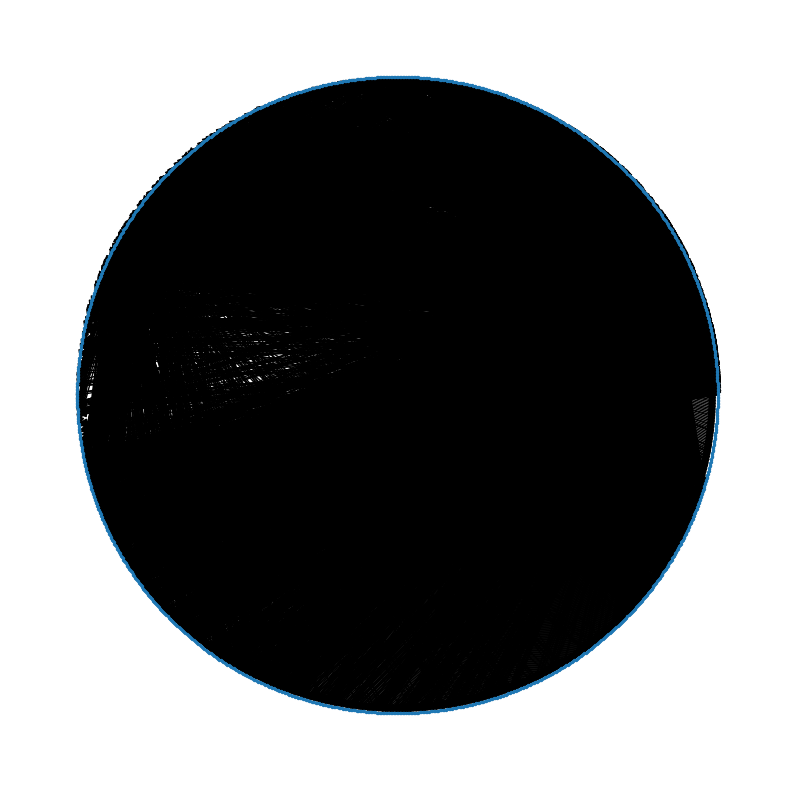

In [289]:
fig, ax = plt.subplots(figsize=(10, 10))

nx.draw(
    G, 
    pos=nx.circular_layout(G),
    node_size=2,
    alpha=1, 
    width=1,
    ax=ax
)   

#nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b', ax=ax[1])


In [290]:
sparse_adj_matrix =nx.adjacency_matrix(G)

In [265]:
adj_matrix = nx.to_numpy_array(G)

In [264]:
import pickle

In [292]:
output = open('data/hci_social_followers.pkl', 'wb')
pickle.dump(followers_dict, output)

7898

In [ ]:
output = open('data/hci_social_following.pkl', 'wb')
pickle.dump(following_dict, output)

In [ ]:
output = open('data/sparse_adj_matrix.pkl', 'wb')
pickle.dump(sparse_adj_matrix, output)